In [1]:
import os
import glob
import math
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import torch

import processing_io as pio
from torch_geometric.transforms import LineGraph

from torch_geometric.data import Data, Batch
import shapely.wkt as wkt
from tqdm import tqdm
import fiona
import os

import alphashape
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm

highway_mapping = {
    'trunk': 0, 'trunk_link': 0, 'motorway_link': 0,
    'primary': 1, 'primary_link': 1,
    'secondary': 2, 'secondary_link': 2,
    'tertiary': 3, 'tertiary_link': 3,
    'residential': 4, 'living_street': 5,
    'pedestrian': 6, 'service': 7,
    'construction': 8, 'unclassified': 9,
    'np.nan': -1
}
result_df_name = 'sim_output_1pm_capacity_reduction_10k_PRELIMINARY'
result_path = '../../../../data/datasets_simulation_outputs/' + result_df_name + '.pt'
string_is_for_1pm = "pop_1pm"

base_dir_sample_sim_input = '../../../../data/' + string_is_for_1pm + '_simulations/' + string_is_for_1pm + '_policies_combinations_with_normal_dist/'
subdirs_pattern = os.path.join(base_dir_sample_sim_input, 'output_networks_*')
subdirs = list(set(glob.glob(subdirs_pattern)))
subdirs.sort()


paris_inside_bvd_peripherique = "../../../../data/paris_inside_bvd_per/referentiel-comptages-edit.shp"
gdf_paris_inside_bvd_per = gpd.read_file(paris_inside_bvd_peripherique)
boundary_df = alphashape.alphashape(gdf_paris_inside_bvd_per, 435).exterior[0]
linear_ring_polygon = Polygon(boundary_df)

gdf_basecase_output_links = gpd.read_file('results/' + string_is_for_1pm + '_basecase_average_output_links.geojson')
gdf_basecase_average_mode_stats = pd.read_csv('results/' + string_is_for_1pm + '_basecase_average_mode_stats.csv', delimiter=';')

## Abstract

This is further than process_output_of_simulations_with_all_output_links_and_eqasim_info.ipynb, as it also includes more input information.

## Process results

Process the outputs of the simulations for further usage by GNN.

In [2]:
# Read all network data into a dictionary of GeoDataFrames
def compute_result_dic_output_links():
    result_dic = {}
    base_network_no_policies = gdf_basecase_output_links
    result_dic["base_network_no_policies"] = base_network_no_policies
    for subdir in tqdm(subdirs, desc="Processing subdirs", unit="subdir"):
        # print(f'Accessing folder: {subdir}')
        # print(len(os.listdir(subdir)))
        networks = [network for network in os.listdir(subdir) if not network.endswith(".DS_Store")]
        for network in networks:
            file_path = os.path.join(subdir, network)
            policy_key = pio.create_policy_key_1pm(network)
            gdf_output_links = pio.read_output_links(file_path)
            if (gdf_output_links is not None):
                gdf_extended = pio.extend_geodataframe(gdf_base=gdf_basecase_output_links, gdf_to_extend=gdf_output_links, column_to_extend='highway', new_column_name='highway')
                gdf_extended = pio.extend_geodataframe(gdf_base=gdf_basecase_output_links, gdf_to_extend=gdf_extended, column_to_extend='vol_car', new_column_name='vol_car_base_case')
                result_dic[policy_key] = gdf_extended
        break
    return result_dic

def calculate_averaged_results(trips_df):
    """Calculate average travel time and routed distance grouped by mode."""
    return trips_df.groupby('mode').agg(
        total_travel_time=('travel_time', 'mean'),
        total_routed_distance=('routed_distance', 'mean')
    ).reset_index()

def compute_result_dic_mode_stats(calculate_averaged_results):
    result_dic_mode_stats = {}
    result_dic_mode_stats["base_network_no_policies"] = gdf_basecase_average_mode_stats
    for subdir in tqdm(subdirs, desc="Processing subdirs", unit="subdir"):
        networks = [network for network in os.listdir(subdir) if not network.endswith(".DS_Store")]
        for network in networks:
            file_path = os.path.join(subdir, network)
            policy_key = pio.create_policy_key_1pm(network)
            df_mode_stats = pd.read_csv(file_path + '/eqasim_trips.csv', delimiter=';')
            averaged_results = calculate_averaged_results(df_mode_stats)
            if (averaged_results is not None):
                result_dic_mode_stats[policy_key] = averaged_results
        break
    return result_dic_mode_stats

def encode_modes(gdf):
    """Encode the 'modes' attribute based on specific strings."""
    modes_conditions = {
        'car': gdf['modes'].str.contains('car', case=False, na=False).astype(int),
        'bus': gdf['modes'].str.contains('bus', case=False, na=False).astype(int),
        'pt': gdf['modes'].str.contains('pt', case=False, na=False).astype(int),
        'train': gdf['modes'].str.contains('train', case=False, na=False).astype(int),
        'rail': gdf['modes'].str.contains('rail', case=False, na=False).astype(int),
        'subway': gdf['modes'].str.contains('subway', case=False, na=False).astype(int)
    }

    # Create a DataFrame from the conditions
    modes_encoded = pd.DataFrame(modes_conditions)

    # Return a tensor of the encoded modes
    return torch.tensor(modes_encoded.values, dtype=torch.float)

result_dic_output_links = compute_result_dic_output_links()
result_dic_mode_stats = compute_result_dic_mode_stats(calculate_averaged_results)

Processing subdirs:   0%|          | 0/70 [00:00<?, ?subdir/s]

Processing subdirs:   0%|          | 0/70 [00:01<?, ?subdir/s]


In [3]:
base_dir_sample_sim_input = '../../../../data/pop_1pm_simulations/idf_1pm/' 
files = os.listdir(base_dir_sample_sim_input)

for file in files:
    file_path = os.path.join(base_dir_sample_sim_input, file)
    base_name, ext = os.path.splitext(file)
    if base_name.startswith("idf_1pm_"):
        base_name = base_name.replace("idf_1pm_", "")
    var_name = base_name  # Start with the cleaned base name
    
    if file.endswith('.csv'):
        try:
            var_name = f"{var_name}_df"  
            globals()[var_name] = pd.read_csv(file_path, sep=";")
            print(f"Loaded CSV file: {file} into variable: {var_name}")
        except Exception as e:
            print(f"Error loading CSV file {file}: {e}")
            
    elif file.endswith('.gpkg'):
        try:
            var_name = f"{var_name}_gdf"  
            layers = fiona.listlayers(file_path)
            
            # Read each layer into a GeoDataFrame
            geodataframes = {layer: gpd.read_file(file_path, layer=layer, geometry = 'geometry', crs="EPSG:2154") for layer in layers}

            # Display the first few rows of each GeoDataFrame
            for layer, gdf in geodataframes.items():
                print(f"Layer: {layer}")
                gdf = gdf.to_crs(epsg=4326)
                
                globals()[var_name] = gdf
                print(f"Loaded GPKG file: {file} into variable: {var_name}")
        except Exception as e:
            print(f"Error loading CSV file {file}: {e}")

Loaded CSV file: idf_1pm_persons.csv into variable: persons_df
Layer: idf_1pm_commutes
Loaded GPKG file: idf_1pm_commutes.gpkg into variable: commutes_gdf
Loaded CSV file: idf_1pm_households.csv into variable: households_df
Loaded CSV file: idf_1pm_trips.csv into variable: trips_df
Loaded CSV file: idf_1pm_activities.csv into variable: activities_df
Loaded CSV file: idf_1pm_vehicle_types.csv into variable: vehicle_types_df
Layer: idf_1pm_trips
Loaded GPKG file: idf_1pm_trips.gpkg into variable: trips_gdf
Layer: idf_1pm_activities
Loaded GPKG file: idf_1pm_activities.gpkg into variable: activities_gdf
Loaded CSV file: idf_1pm_vehicles.csv into variable: vehicles_df
Layer: idf_1pm_homes
Loaded GPKG file: idf_1pm_homes.gpkg into variable: homes_gdf


In [4]:
base_gdf = result_dic_output_links["base_network_no_policies"]
links_gdf = gpd.GeoDataFrame(base_gdf, geometry='geometry')
links_gdf.crs = "EPSG:2154"  # Assuming the original CRS is EPSG:2154
links_gdf.to_crs("EPSG:4326", inplace=True)

In [5]:
homes_gdf = globals()["homes_gdf"]
households_df = globals()["households_df"]
population_df = pd.read_csv("intermediate_results/population.csv")
persons_df = globals()["persons_df"]

sorted_population_df = population_df.sort_values(by="id")
sorted_persons_df = persons_df.sort_values(by="person_id")
merged_df = pd.merge(sorted_persons_df, sorted_population_df, left_on="person_id", right_on="id")
removed_some_columns = merged_df.copy()
removed_some_columns = removed_some_columns.drop(columns=['employed_y', 'hasPtSubscription', 'householdId', 'sex_y', 'htsPersonId', 'censusPersonId', 'hasLicense', 'id', 'age_y'])
updated_persons = removed_some_columns.copy()
persons_with_homes = homes_gdf.merge(updated_persons, on='household_id', how='right')

print(persons_with_homes.head())

   household_id                  geometry  person_id  age_x  employed_x  \
0          1084  POINT (2.37653 48.86644)       1972     23        True   
1          1084  POINT (2.37653 48.86644)       1973     23        True   
2          1590  POINT (2.37969 48.84590)       2973     39       False   
3          2921  POINT (2.32901 48.89036)       5524     32        True   
4          2921  POINT (2.32901 48.89036)       5525     31        True   

    sex_x  socioprofessional_class  has_driving_license  has_pt_subscription  \
0    male                        4                 True                 True   
1  female                        4                 True                 True   
2    male                        6                 True                 True   
3  female                        4                False                False   
4    male                        5                False                False   

   census_person_id  hts_id bikeAvailability carAvailability  \
0   

In [6]:
# Create a GeoDataFrame for homes_gdf if not already a GeoDataFrame
if not isinstance(persons_with_homes, gpd.GeoDataFrame):
    persons_with_homes = gpd.GeoDataFrame(persons_with_homes, geometry=gpd.points_from_xy(persons_with_homes.longitude, persons_with_homes.latitude), crs= links_gdf.crs)

# Ensure both GeoDataFrames have the same CRS
utm_crs = 'EPSG:32631'  # UTM zone 31N

def compute_close_homes(gdf_base_input:pd.DataFrame, persons_with_homes_input:pd.DataFrame, utm_crs:str):
    gdf_base = gdf_base_input.copy()
    persons_with_homes = persons_with_homes_input.copy()
    close_homes_count = []
    gdf_base_utm = gdf_base.to_crs(utm_crs)
    persons_with_homes_utm = persons_with_homes.to_crs(utm_crs)
    for i, row in tqdm(enumerate(gdf_base_utm.iterrows()), desc="Processing rows", unit="row"):
        buffer_utm = row[1].geometry.buffer(distance=50)
        buffer = gpd.GeoSeries([buffer_utm], crs=utm_crs).to_crs(gdf_base_utm.crs)[0]
        # count = persons_with_homes_utm[persons_with_homes_utm.geometry.within(buffer)].shape[0]
        matching_homes = persons_with_homes_utm[persons_with_homes_utm.geometry.within(buffer)]
        socioprofessional_classes = matching_homes['socioprofessional_class'].tolist()
        close_homes_count.append((len(socioprofessional_classes), socioprofessional_classes))
        # close_homes_count.append(count)
    return close_homes_count

links_within_linear_ring_gdf = links_gdf[links_gdf.geometry.within(linear_ring_polygon)]
persons_with_home_within_linear_ring = persons_with_homes[persons_with_homes.geometry.within(linear_ring_polygon)]

close_homes_count_normal = compute_close_homes(gdf_base_input = links_gdf, persons_with_homes_input = persons_with_homes, utm_crs = utm_crs)
# close_homes_count_within_linear_ring = compute_close_homes(gdf_base_input = links_within_linear_ring_gdf, persons_with_homes_input = persons_with_home_within_linear_ring, utm_crs = utm_crs)

links_gdf['close_homes_count'] = close_homes_count_normal


Processing rows: 31216row [01:10, 441.20row/s]
Processing rows: 478row [00:00, 493.82row/s]


KeyboardInterrupt: 

In [11]:
close_homes_count_normal

[(0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (3, [8, 7, 7]),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (1, [3]),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (1, [7]),
 (1, [7]),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (1, [7]),
 (1, [7]),
 (1, [7]),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (1, [7]),
 (1, [7]),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (4, [8, 8, 4, 8]),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (0, []),
 (1, [3]),
 (1, [3]),
 (0, []),
 (0, []),
 (0, []),
 (5, [8, 4, 8, 8, 5]),
 (5, [8, 4, 8, 8, 5]),
 (0, []),
 (0, []),
 (0, []

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_4951/523158859.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  scatter = plt.scatter(links_gdf.geometry.centroid.x,
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_4951/523158859.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  links_gdf.geometry.centroid.y,


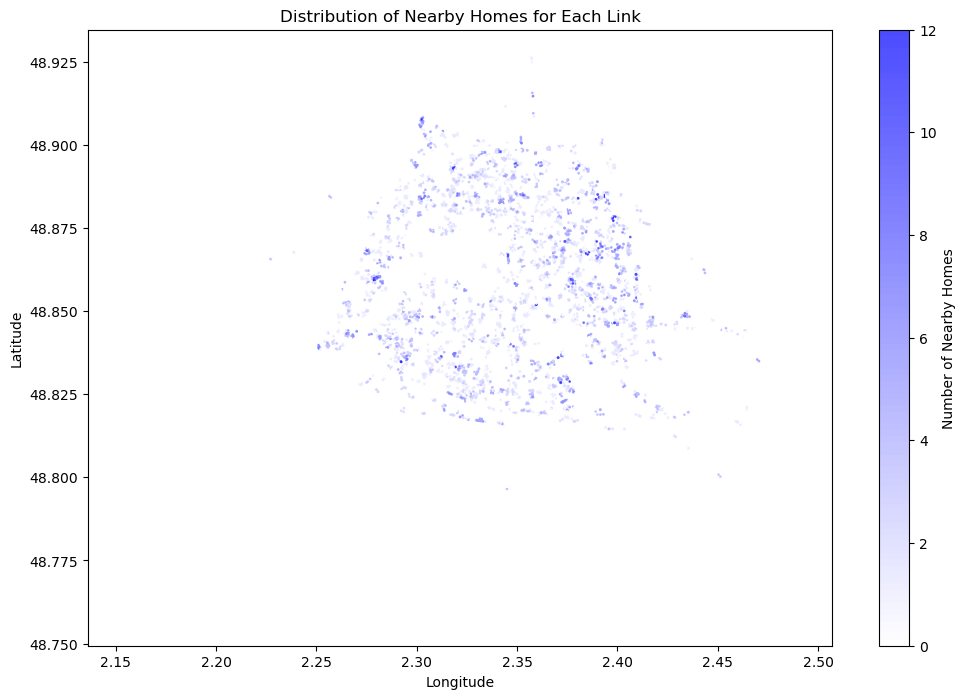

Maximum number of nearby homes: 12
Minimum number of nearby homes: 0
Average number of nearby homes: 0.39


In [23]:
from matplotlib.colors import LinearSegmentedColormap


home_counts = [count for count, _ in close_homes_count_normal]

# Create a custom white-to-blue color map
colors = [(1, 1, 1), (0, 0, 1)]  # White to Blue
n_bins = 100  # Number of color gradations
cmap = LinearSegmentedColormap.from_list('white_to_blue', colors, N=n_bins)

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(links_gdf.geometry.centroid.x, 
                      links_gdf.geometry.centroid.y, 
                      c=home_counts, 
                      s=1,  # Adjust point size as needed
                      cmap=cmap, 
                      norm=norm, 
                      alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Number of Nearby Homes')

# Set labels and title
plt.title('Distribution of Nearby Homes for Each Link')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# Print some statistics
print(f"Maximum number of nearby homes: {max(home_counts)}")
print(f"Minimum number of nearby homes: {min(home_counts)}")
print(f"Average number of nearby homes: {np.mean(home_counts):.2f}")

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_4951/1644234036.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  valid_points = [(x, y, cls) for x, y, cls in zip(links_gdf.geometry.centroid.x,
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_4951/1644234036.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  links_gdf.geometry.centroid.y,


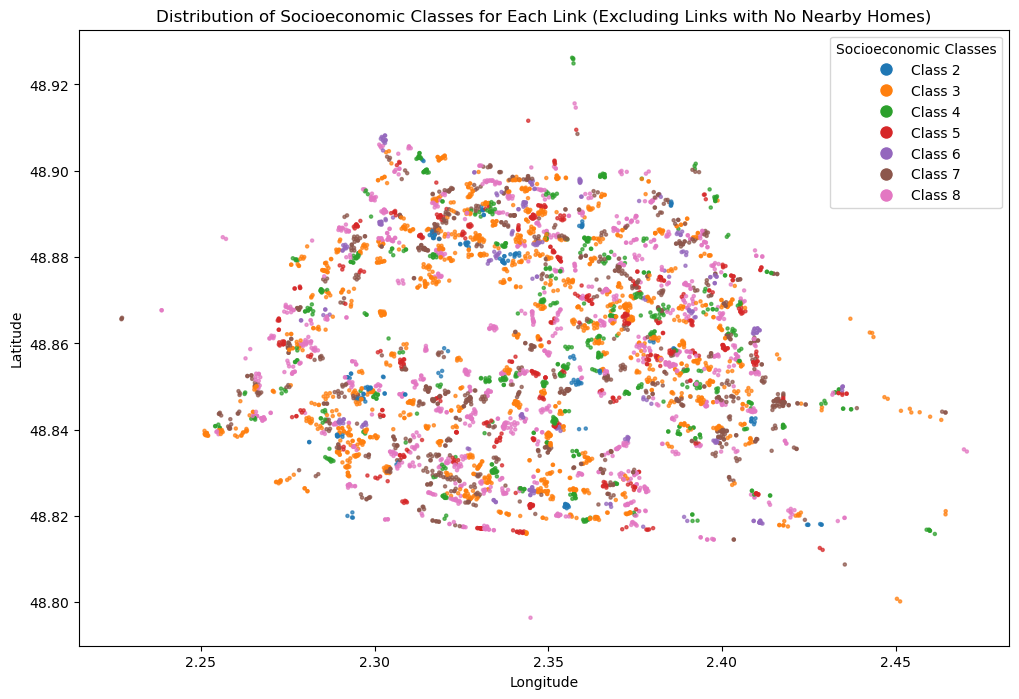

Number of unique socioeconomic classes: 7
Socioeconomic classes present: [2, 3, 4, 5, 6, 7, 8]
Number of links with nearby homes: 5329
Number of links without nearby homes: 25887


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Extract the socioeconomic classes from the tuples
socioeconomic_classes = [classes for _, classes in close_homes_count_normal]

# Function to get the most common class
def most_common_class(classes):
    if not classes:
        return None  # No nearby homes
    return Counter(classes).most_common(1)[0][0]

# Get the most common class for each point
most_common_classes = [most_common_class(classes) for classes in socioeconomic_classes]

# Filter out None values (links with no nearby homes)
valid_points = [(x, y, cls) for x, y, cls in zip(links_gdf.geometry.centroid.x, 
                                                 links_gdf.geometry.centroid.y, 
                                                 most_common_classes) if cls is not None]

# Unzip the filtered points
x_coords, y_coords, filtered_classes = zip(*valid_points)

# Get unique classes (excluding None)
unique_classes = sorted(set(filtered_classes))

# Create a color map
cmap = plt.get_cmap('tab10')  # Using a categorical colormap
colors = [cmap(i) for i in range(len(unique_classes))]

# Create a mapping of class to color
class_to_color = {cls: color for cls, color in zip(unique_classes, colors)}

# Map classes to colors
point_colors = [class_to_color[cls] for cls in filtered_classes]

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(x_coords, y_coords, 
                      c=point_colors, 
                      s=5,  # Adjust point size as needed
                      alpha=0.7)

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Class {cls}', 
                   markerfacecolor=color, markersize=10) 
                   for cls, color in class_to_color.items()]
plt.legend(handles=legend_elements, title="Socioeconomic Classes", loc="upper right")

# Set labels and title
plt.title('Distribution of Socioeconomic Classes for Each Link (Excluding Links with No Nearby Homes)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# Print some statistics
print(f"Number of unique socioeconomic classes: {len(unique_classes)}")
print(f"Socioeconomic classes present: {unique_classes}")
print(f"Number of links with nearby homes: {len(valid_points)}")
print(f"Number of links without nearby homes: {len(most_common_classes) - len(valid_points)}")

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_4951/1033126323.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  valid_points = [(x, y, cls) for x, y, cls in zip(links_gdf.geometry.centroid.x,
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_4951/1033126323.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  links_gdf.geometry.centroid.y,


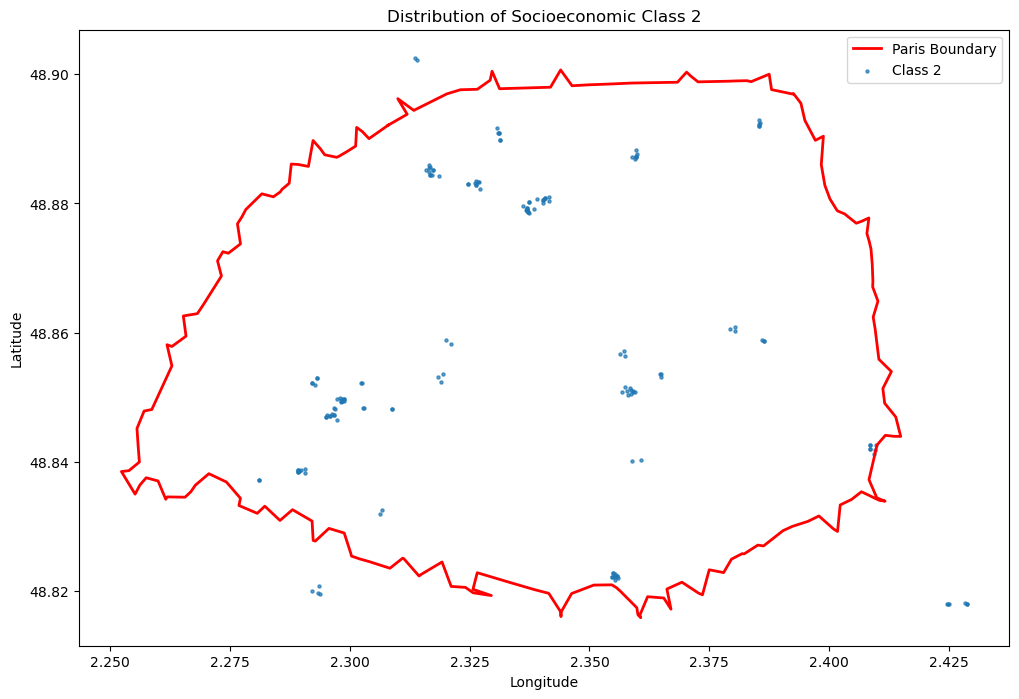

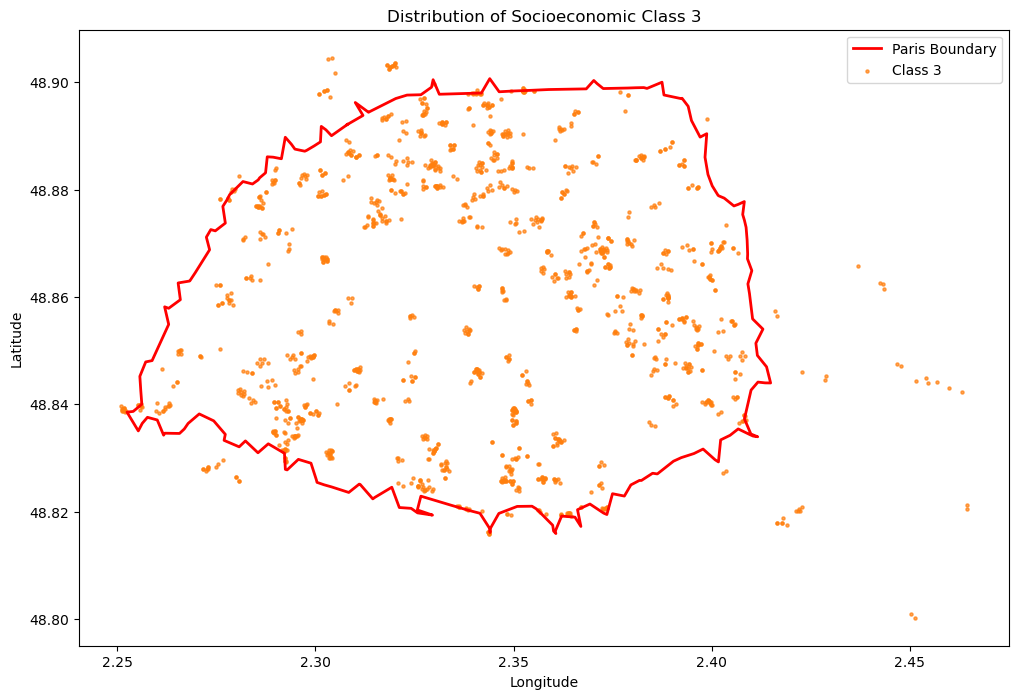

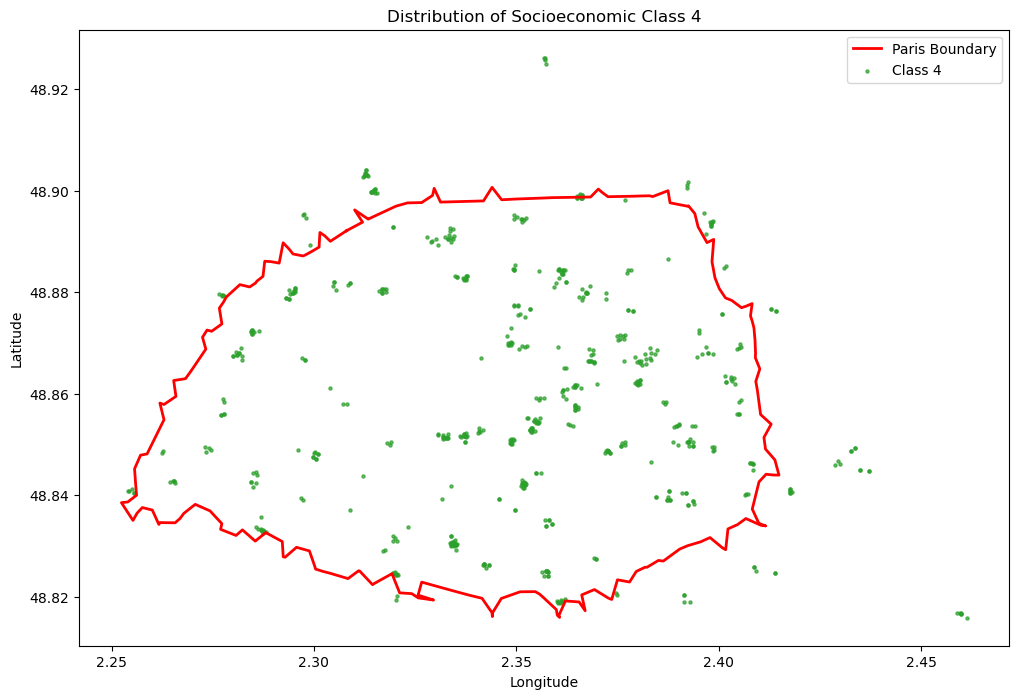

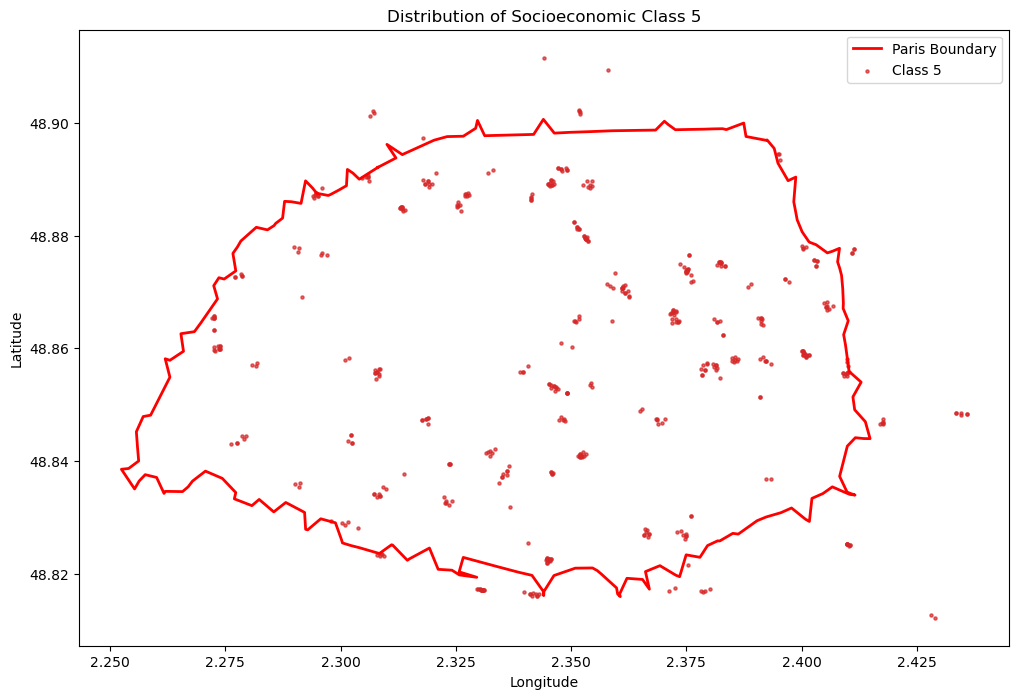

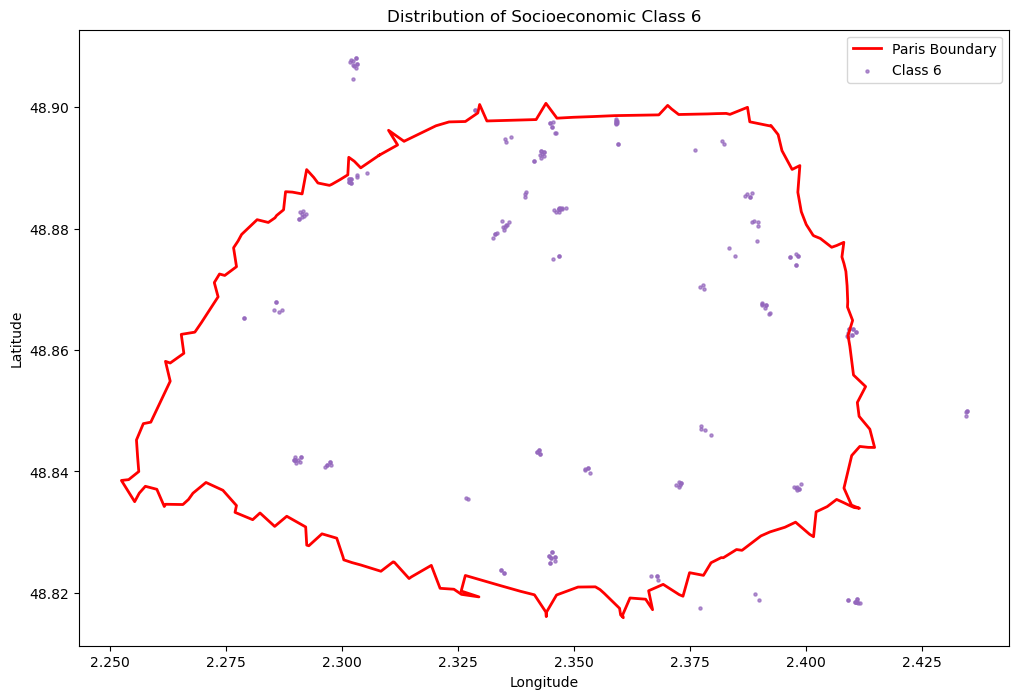

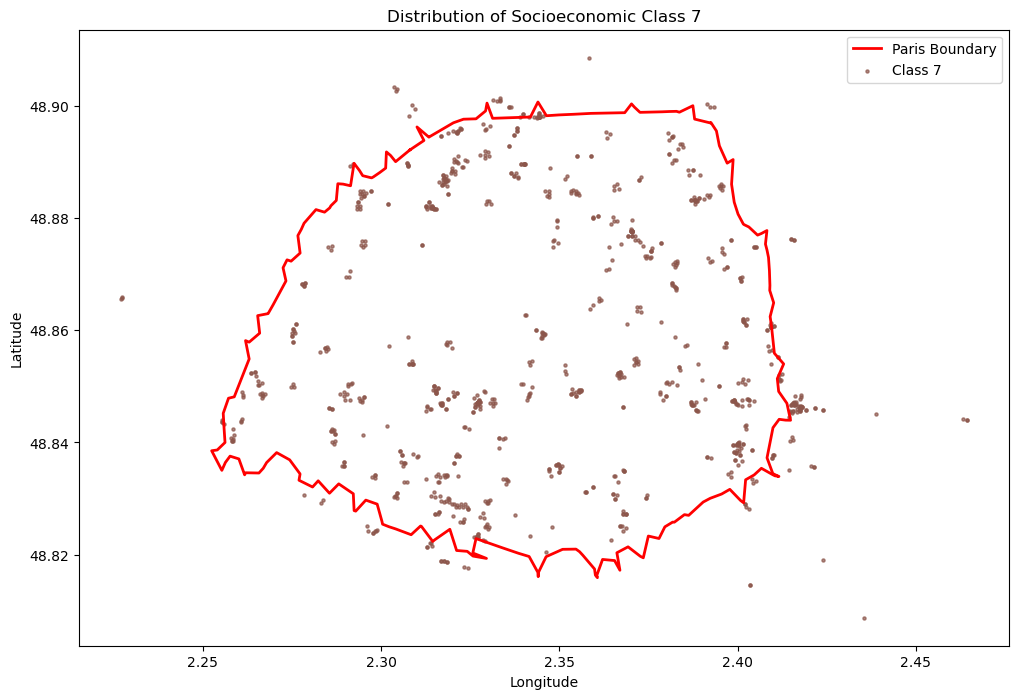

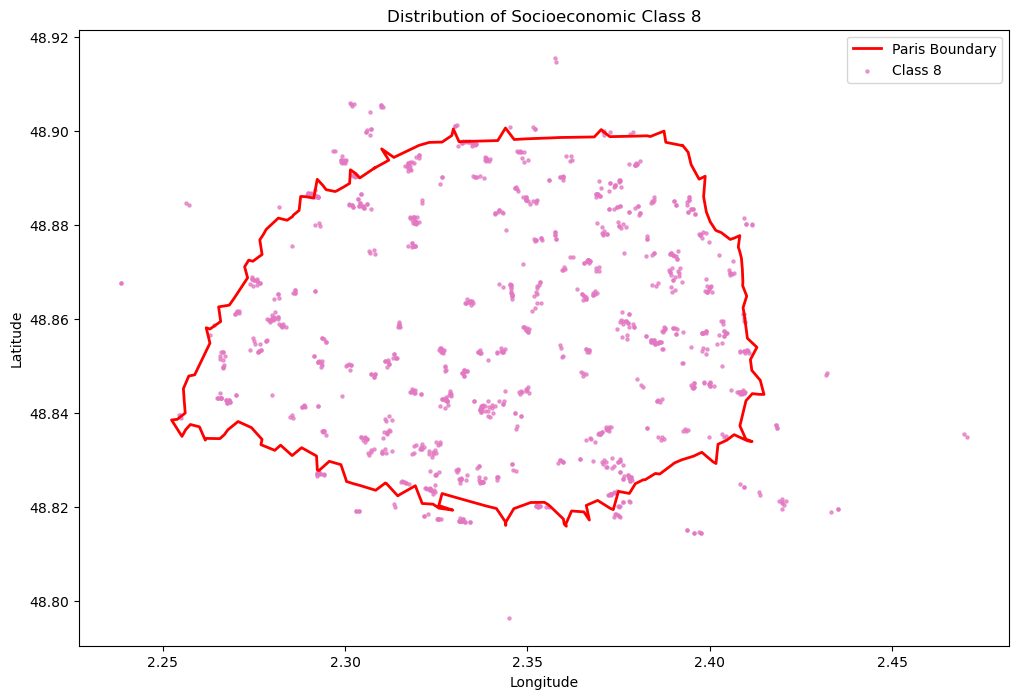

Number of unique socioeconomic classes: 7
Socioeconomic classes present: [2, 3, 4, 5, 6, 7, 8]
Number of links with nearby homes: 5329
Number of links without nearby homes: 25887


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Extract the socioeconomic classes from the tuples
socioeconomic_classes = [classes for _, classes in close_homes_count_normal]

# Function to get the most common class
def most_common_class(classes):
    if not classes:
        return None  # No nearby homes
    return Counter(classes).most_common(1)[0][0]

# Get the most common class for each point
most_common_classes = [most_common_class(classes) for classes in socioeconomic_classes]

# Filter out None values (links with no nearby homes)
valid_points = [(x, y, cls) for x, y, cls in zip(links_gdf.geometry.centroid.x, 
                                                 links_gdf.geometry.centroid.y, 
                                                 most_common_classes) if cls is not None]

# Unzip the filtered points
x_coords, y_coords, filtered_classes = zip(*valid_points)

# Get unique classes (excluding None)
unique_classes = sorted(set(filtered_classes))

# Create a color map
cmap = plt.get_cmap('tab10')  # Using a categorical colormap
colors = [cmap(i) for i in range(len(unique_classes))]

# Create a mapping of class to color
class_to_color = {cls: color for cls, color in zip(unique_classes, colors)}

# Extract coordinates of the linear ring
ring_x, ring_y = linear_ring_polygon.exterior.xy

# Create a separate plot for each class
for cls in unique_classes:
    # Filter points for this class
    class_points = [(x, y) for x, y, c in valid_points if c == cls]
    if class_points:
        x_class, y_class = zip(*class_points)
        
        plt.figure(figsize=(12, 8))
        
        # Plot the linear ring
        plt.plot(ring_x, ring_y, color='red', linewidth=2, label='Paris Boundary')
        
        # Plot the class points
        plt.scatter(x_class, y_class, 
                    c=[class_to_color[cls]], 
                    s=5,  # Adjust point size as needed
                    alpha=0.7,
                    label=f'Class {cls}')
        
        plt.title(f'Distribution of Socioeconomic Class {cls}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.show()

# Print some statistics
print(f"Number of unique socioeconomic classes: {len(unique_classes)}")
print(f"Socioeconomic classes present: {unique_classes}")
print(f"Number of links with nearby homes: {len(valid_points)}")
print(f"Number of links without nearby homes: {len(most_common_classes) - len(valid_points)}")

In [14]:
import torch

# Extract the socio-professional classes and their counts
socio_professional_classes = [item[1] for item in close_homes_count_normal]
class_counts = [item[0] for item in close_homes_count_normal]

# Get unique socio-professional classes
unique_classes = set([cls for sublist in socio_professional_classes for cls in sublist])
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}

# Initialize a tensor to hold the counts
tensor_shape = (len(close_homes_count_normal), len(unique_classes))
close_homes_tensor = torch.zeros(tensor_shape)

# Fill the tensor with counts
for i, classes in enumerate(socio_professional_classes):
    for cls in classes:
        close_homes_tensor[i, class_to_index[cls]] += 1

# Convert the tensor to a sparse tensor to save memory
close_homes_tensor_sparse = close_homes_tensor.to_sparse()

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_4951/2349420541.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plt.scatter(links_within_linear_ring_gdf.geometry.centroid.x, links_within_linear_ring_gdf.geometry.centroid.y, c=close_homes_count_normal, s=1, cmap='coolwarm', alpha=0.7)


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [(0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (5, [8, 4, 8, 8, 5]), (5, [8, 4, 8, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (2, [8, 3]), (1, [3]), (1, [3]), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (5, [4, 3, 3, 8, 8]), (5, [4, 3, 3, 8, 8]), (3, [3, 8, 8]), (3, [3, 8, 8]), (0, []), (0, []), (0, []), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (5, [8, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 8]), (2, [5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (4, [7, 5, 6, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (2, [5, 7]), (3, [3, 4, 8]), (3, [3, 4, 8]), (1, [7]), (1, [7]), (0, []), (0, []), (2, [6, 5]), (2, [6, 5]), (3, [3, 4, 8]), (3, [3, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 8, 8, 6]), (4, [4, 8, 8, 6]), (4, [4, 8, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (2, [5, 7]), (0, []), (3, [4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (2, [7, 8]), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (4, [8, 8, 8, 3]), (4, [8, 8, 8, 3]), (7, [8, 3, 3, 8, 8, 8, 3]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (8, [7, 4, 8, 7, 4, 2, 8, 8]), (8, [7, 4, 8, 7, 4, 2, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 5, 5]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [2]), (1, [2]), (0, []), (0, []), (3, [8, 6, 3]), (3, [8, 6, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 5]), (2, [4, 5]), (3, [3, 3, 8]), (3, [3, 3, 8]), (1, [6]), (0, []), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [3]), (1, [3]), (0, []), (0, []), (5, [6, 7, 5, 4, 3]), (5, [6, 7, 5, 4, 3]), (4, [3, 8, 8, 3]), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 5]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [5]), (1, [5]), (1, [5]), (1, [4]), (1, [4]), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (4, [8, 2, 8, 8]), (4, [8, 2, 8, 8]), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (4, [8, 8, 4, 3]), (1, [8]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 5, 8, 8]), (0, []), (0, []), (1, [8]), (2, [8, 8]), (2, [8, 8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (2, [3, 3]), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (3, [2, 5, 4]), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (3, [3, 3, 4]), (3, [3, 3, 4]), (4, [3, 3, 4, 7]), (4, [3, 3, 4, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 3]), (3, [2, 2, 4]), (2, [2, 4]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 2, 8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 4]), (3, [8, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 4]), (3, [8, 3, 4]), (3, [8, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (3, [5, 5, 3]), (4, [8, 3, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (5, [4, 8, 3, 4, 4]), (3, [4, 8, 3]), (5, [4, 2, 3, 4, 8]), (3, [3, 4, 8]), (3, [3, 4, 8]), (5, [4, 2, 3, 4, 8]), (0, []), (0, []), (0, []), (1, [4]), (4, [8, 5, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (1, [7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (4, [3, 8, 8, 3]), (0, []), (3, [5, 8, 8]), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (2, [4, 4]), (2, [4, 4]), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (3, [3, 3, 8]), (3, [3, 3, 8]), (4, [3, 3, 3, 8]), (4, [3, 3, 3, 8]), (4, [3, 3, 3, 8]), (4, [3, 3, 3, 8]), (4, [3, 3, 3, 8]), (4, [3, 3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 3, 8, 8, 3]), (5, [8, 3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 8]), (3, [3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 8]), (3, [3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 4, 8, 3]), (3, [4, 3, 8]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (1, [7]), (0, []), (0, []), (0, []), (3, [5, 6, 3]), (3, [5, 6, 3]), (6, [7, 8, 7, 5, 6, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 8, 8, 3]), (4, [4, 8, 8, 3]), (5, [8, 4, 8, 8, 3]), (5, [8, 4, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 6]), (3, [7, 3, 6]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [6, 4, 5, 6, 6]), (0, []), (5, [6, 4, 5, 6, 6]), (0, []), (0, []), (9, [8, 2, 8, 8, 8, 3, 8, 8, 3]), (5, [8, 3, 8, 8, 3]), (4, [8, 2, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (4, [8, 3, 8, 8]), (7, [3, 7, 3, 4, 8, 8, 8]), (5, [3, 7, 8, 8, 8]), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (9, [3, 4, 3, 4, 8, 8, 8, 8, 8]), (7, [3, 4, 3, 4, 8, 8, 8]), (2, [3, 4]), (2, [3, 4]), (5, [3, 7, 8, 8, 8]), (5, [3, 7, 8, 8, 8]), (9, [3, 7, 3, 4, 3, 4, 8, 8, 8]), (9, [3, 7, 3, 4, 3, 4, 8, 8, 8]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 7]), (2, [3, 7]), (0, []), (3, [5, 5, 6]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (6, [3, 8, 8, 3, 3, 5]), (0, []), (2, [3, 7]), (0, []), (0, []), (3, [8, 8, 3]), (3, [5, 8, 8]), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (2, [7, 2]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 4, 8, 8, 5]), (5, [8, 4, 8, 8, 5]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (4, [8, 4, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 3, 8, 8]), (3, [3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [3, 3]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (3, [3, 3, 4]), (12, [3, 3, 8, 3, 8, 8, 3, 8, 4, 3, 8, 2]), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 6, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (1, [8]), (0, []), (0, []), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (6, [3, 4, 8, 8, 4, 8]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (2, [8, 3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 6, 5]), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (3, [7, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (2, [7, 3]), (2, [3, 3]), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (2, [5, 6]), (2, [5, 6]), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (3, [8, 4, 4]), (3, [8, 4, 4]), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (2, [3, 5]), (0, []), (0, []), (3, [8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 8, 3]), (3, [4, 8, 3]), (0, []), (0, []), (3, [5, 3, 7]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 8]), (3, [2, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 8, 8, 2, 8, 4]), (6, [3, 8, 8, 2, 8, 4]), (0, []), (0, []), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (6, [3, 8, 8, 2, 8, 4]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (2, [3, 4]), (2, [3, 4]), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (4, [8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (2, [8, 3]), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [7]), (0, []), (0, []), (2, [5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 3, 6, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [7]), (0, []), (6, [3, 8, 8, 2, 8, 4]), (6, [3, 8, 8, 2, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (8, [2, 8, 3, 8, 8, 8, 3, 3]), (8, [2, 8, 3, 8, 8, 8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (1, [7]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 4, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 8, 8, 3, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (2, [3, 4]), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (4, [3, 3, 8, 3]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 4, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (0, []), (1, [7]), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 4]), (3, [3, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 3, 8]), (3, [4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [5, 6, 4, 5]), (4, [5, 6, 4, 5]), (4, [5, 6, 4, 5]), (4, [5, 6, 4, 5]), (4, [5, 6, 4, 5]), (4, [5, 6, 4, 5]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 3, 4]), (4, [8, 8, 3, 4]), (4, [8, 8, 3, 4]), (4, [8, 8, 3, 4]), (8, [5, 6, 4, 5, 8, 8, 3, 4]), (8, [5, 6, 4, 5, 8, 8, 3, 4]), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (4, [3, 4, 8, 5]), (4, [3, 4, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 8]), (3, [8, 5, 8]), (0, []), (0, []), (8, [7, 8, 8, 8, 8, 8, 8, 6]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (1, [4]), (3, [4, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 3]), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (3, [4, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (2, [5, 3]), (0, []), (1, [5]), (0, []), (0, []), (2, [3, 6]), (1, [3]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 4]), (0, []), (0, []), (0, []), (0, []), (2, [2, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (3, [6, 7, 8]), (3, [6, 7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [6, 7, 8]), (0, []), (3, [6, 7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (2, [7, 8]), (3, [7, 8, 3]), (11, [3, 7, 8, 8, 8, 8, 8, 6, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (2, [7, 8]), (2, [7, 8]), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 2]), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [5, 6, 3, 7, 7]), (5, [7, 7, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (4, [7, 8, 7, 5]), (4, [7, 8, 7, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (2, [8, 3]), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 6, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 8]), (3, [8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (2, [3, 3]), (3, [4, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (2, [6, 3]), (2, [6, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (2, [8, 8]), (2, [8, 8]), (1, [8]), (0, []), (4, [8, 8, 4, 5]), (0, []), (0, []), (0, []), (4, [8, 8, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 6]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 3, 2, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 2]), (2, [5, 2]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (3, [4, 7, 7]), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (3, [4, 7, 7]), (3, [4, 7, 7]), (3, [4, 7, 7]), (3, [4, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 3, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [6, 8, 8, 3, 8]), (5, [6, 8, 8, 3, 8]), (3, [5, 4, 4]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 7, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 2]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (2, [5, 3]), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (5, [5, 8, 8, 5, 8]), (5, [5, 8, 8, 5, 8]), (1, [5]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (4, [8, 8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (4, [6, 3, 8, 3]), (0, []), (2, [7, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (4, [8, 8, 4, 5]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (2, [4, 3]), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (3, [8, 6, 8]), (3, [8, 6, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (2, [7, 3]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (2, [7, 3]), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 7]), (2, [3, 7]), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 7, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 4, 4]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (3, [3, 4, 5]), (3, [3, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 3, 8, 8]), (4, [7, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 4, 8]), (5, [8, 5, 8, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 8, 8]), (4, [8, 3, 8, 8]), (4, [8, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (3, [3, 8, 3]), (1, [3]), (1, [3]), (5, [8, 3, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (1, [4]), (1, [4]), (2, [3, 5]), (2, [3, 5]), (2, [3, 5]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 4, 5]), (4, [5, 4, 5, 4]), (0, []), (2, [3, 3]), (3, [4, 3, 3]), (7, [8, 3, 5, 5, 4, 5, 4]), (0, []), (5, [8, 3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (3, [3, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 8, 5]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 4]), (0, []), (0, []), (3, [4, 4, 3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 3]), (0, []), (0, []), (3, [8, 8, 4]), (3, [8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 4]), (3, [8, 8, 4]), (3, [8, 8, 4]), (3, [8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 3, 3, 3]), (4, [7, 3, 3, 3]), (4, [7, 3, 3, 3]), (4, [7, 3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (5, [8, 8, 3, 4, 8]), (5, [8, 8, 3, 4, 8]), (0, []), (0, []), (1, [3]), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (2, [8, 3]), (0, []), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (2, [3, 4]), (2, [3, 4]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (4, [8, 8, 4, 8]), (0, []), (0, []), (4, [8, 8, 4, 8]), (2, [3, 4]), (0, []), (0, []), (4, [8, 3, 4, 8]), (4, [8, 3, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [7, 8, 7, 5, 5, 8]), (1, [3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (3, [2, 4, 8]), (0, []), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (5, [8, 8, 4, 8, 3]), (5, [8, 8, 4, 8, 3]), (7, [8, 8, 4, 8, 3, 3, 3]), (7, [8, 8, 4, 8, 3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (5, [5, 4, 3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (8, [5, 4, 4, 8, 8, 3, 3, 8]), (9, [3, 3, 8, 7, 7, 8, 3, 3, 7]), (0, []), (0, []), (1, [3]), (2, [5, 7]), (2, [5, 7]), (5, [5, 4, 4, 8, 8]), (5, [5, 4, 4, 8, 8]), (0, []), (0, []), (4, [8, 8, 5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 6]), (2, [7, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 5]), (0, []), (4, [4, 4, 8, 8]), (0, []), (0, []), (0, []), (0, []), (4, [3, 4, 3, 8]), (0, []), (4, [3, 4, 3, 8]), (0, []), (3, [4, 8, 8]), (3, [4, 8, 8]), (0, []), (0, []), (2, [8, 8]), (5, [6, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (4, [3, 8, 3, 8]), (4, [3, 8, 3, 8]), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 3]), (3, [8, 4, 3]), (0, []), (4, [3, 8, 8, 3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 4, 4]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (4, [4, 4, 2, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 3]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 3, 5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (3, [8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (3, [2, 3, 8]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (5, [6, 7, 5, 4, 3]), (5, [6, 7, 5, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (4, [7, 4, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 3]), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (5, [4, 8, 8, 6, 4]), (0, []), (2, [7, 7]), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 2, 3]), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [4, 8, 8, 4, 8]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 6, 8, 8, 7]), (5, [8, 6, 8, 8, 7]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [7, 6, 8, 3, 3, 8]), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 4]), (3, [8, 4, 4]), (3, [8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (3, [4, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (4, [8, 5, 4, 4]), (4, [8, 5, 4, 4]), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (7, [8, 3, 3, 8, 8, 3, 3]), (5, [8, 3, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 2, 8, 8, 4]), (5, [8, 2, 8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (2, [2, 6]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (2, [6, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 3]), (3, [7, 3, 3]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (2, [7, 2]), (0, []), (0, []), (1, [8]), (1, [8]), (1, [3]), (1, [3]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (2, [3, 3]), (3, [7, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (2, [8, 3]), (2, [8, 3]), (0, []), (2, [3, 3]), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 2]), (2, [6, 2]), (2, [3, 5]), (2, [3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 5, 8, 8]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 5, 8, 8]), (5, [8, 8, 5, 8, 8]), (3, [3, 7, 8]), (5, [8, 8, 5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (4, [8, 4, 4, 8]), (5, [3, 8, 3, 4, 4]), (0, []), (5, [3, 8, 3, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (1, [4]), (0, []), (0, []), (3, [3, 8, 3]), (3, [3, 8, 3]), (3, [3, 8, 3]), (3, [3, 8, 3]), (4, [6, 5, 8, 7]), (4, [6, 5, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 3, 3, 3]), (4, [7, 3, 3, 3]), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 2, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 2, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (9, [8, 2, 8, 8, 8, 3, 8, 8, 3]), (4, [8, 2, 8, 8]), (0, []), (0, []), (4, [5, 8, 4, 3]), (0, []), (2, [3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (10, [8, 8, 5, 6, 5, 2, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (10, [3, 4, 3, 4, 8, 8, 8, 8, 8, 8]), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (0, []), (1, [8]), (1, [8]), (1, [8]), (2, [7, 3]), (2, [7, 3]), (0, []), (0, []), (1, [5]), (1, [5]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (3, [8, 3, 3]), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (2, [6, 6]), (2, [6, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (5, [6, 5, 8, 8, 8]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (2, [6, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 5]), (0, []), (2, [6, 5]), (2, [6, 5]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 8]), (1, [7]), (1, [7]), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (2, [5, 8]), (2, [5, 8]), (0, []), (4, [7, 8, 7, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (4, [8, 3, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (5, [8, 3, 2, 8, 8]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (5, [3, 8, 4, 7, 7]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 3]), (3, [3, 3, 3]), (2, [7, 3]), (0, []), (0, []), (3, [3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (1, [5]), (1, [3]), (1, [3]), (2, [5, 7]), (2, [5, 7]), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (5, [6, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (5, [3, 8, 3, 8, 8]), (5, [3, 8, 3, 8, 8]), (0, []), (0, []), (0, []), (5, [3, 8, 3, 8, 8]), (0, []), (4, [6, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 4]), (0, []), (0, []), (2, [2, 6]), (2, [2, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 2]), (2, [2, 2]), (2, [2, 2]), (2, [2, 2]), (2, [2, 2]), (2, [2, 2]), (2, [2, 2]), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 2]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 7]), (2, [4, 7]), (2, [4, 7]), (2, [4, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 8, 5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 7, 7]), (3, [2, 7, 7]), (2, [4, 4]), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 3]), (3, [2, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 4, 8, 3]), (3, [2, 7, 7]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 5, 6, 6]), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (2, [7, 7]), (5, [2, 4, 8, 7, 7]), (3, [2, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 8, 3]), (4, [8, 5, 8, 3]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 5]), (0, []), (0, []), (0, []), (5, [8, 8, 8, 6, 4]), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (3, [4, 4, 3]), (3, [4, 4, 3]), (4, [3, 4, 4, 3]), (4, [3, 4, 4, 3]), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 3]), (3, [8, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 4, 3]), (3, [4, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 8, 7]), (4, [8, 4, 8, 7]), (4, [8, 4, 8, 7]), (0, []), (0, []), (3, [2, 8, 5]), (3, [2, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (4, [3, 8, 8, 8]), (4, [3, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (3, [5, 4, 4]), (2, [4, 4]), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (2, [2, 2]), (0, []), (2, [2, 2]), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (2, [4, 4]), (0, []), (3, [5, 4, 4]), (0, []), (0, []), (3, [5, 4, 4]), (1, [5]), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (2, [3, 8]), (2, [3, 8]), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (2, [2, 2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 3, 3, 8]), (5, [8, 8, 3, 3, 8]), (5, [8, 8, 3, 3, 8]), (5, [8, 8, 3, 3, 8]), (4, [4, 8, 8, 3]), (4, [4, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (4, [3, 3, 4, 7]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (5, [8, 6, 8, 8, 7]), (0, []), (1, [8]), (5, [8, 8, 3, 3, 8]), (5, [8, 8, 3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (4, [2, 8, 2, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 6, 8, 8, 7]), (5, [8, 6, 8, 8, 7]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 4, 5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 8, 3, 8]), (4, [6, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (8, [8, 4, 5, 4, 8, 6, 8, 5]), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 3]), (3, [8, 3, 3]), (3, [8, 3, 3]), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (2, [3, 8]), (2, [3, 8]), (2, [3, 8]), (1, [8]), (1, [8]), (3, [8, 3, 4]), (0, []), (1, [6]), (0, []), (0, []), (3, [5, 6, 3]), (3, [5, 6, 3]), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (4, [8, 3, 8, 8]), (3, [3, 3, 3]), (3, [3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (1, [2]), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (2, [8, 3]), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 3]), (3, [7, 3, 3]), (3, [7, 3, 3]), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 8, 6, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 5]), (2, [8, 5]), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 3]), (3, [8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 3, 8, 8]), (4, [3, 3, 8, 8]), (4, [3, 3, 8, 8]), (4, [3, 3, 8, 8]), (4, [3, 3, 8, 8]), (4, [3, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 8, 8]), (4, [8, 4, 8, 8]), (0, []), (3, [5, 6, 5]), (0, []), (3, [3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 5, 5]), (2, [5, 5]), (0, []), (0, []), (0, []), (0, []), (4, [6, 8, 8, 6]), (0, []), (1, [8]), (0, []), (4, [8, 8, 5, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (10, [7, 8, 8, 5, 2, 8, 3, 8, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 8, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 4]), (5, [8, 3, 8, 4, 3]), (4, [5, 8, 8, 5]), (3, [4, 5, 5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (1, [7]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [3]), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 5, 5]), (4, [4, 5, 7, 5]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (5, [6, 4, 5, 6, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 4, 3, 8]), (4, [6, 4, 3, 8]), (0, []), (0, []), (5, [8, 4, 8, 8, 6]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (9, [8, 3, 8, 8, 3, 8, 3, 8, 2]), (0, []), (0, []), (0, []), (2, [8, 5]), (1, [5]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 2]), (2, [5, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (1, [3]), (1, [3]), (1, [7]), (0, []), (1, [7]), (0, []), (0, []), (4, [3, 8, 3, 8]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (4, [3, 8, 3, 8]), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (2, [3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 7, 8]), (4, [8, 4, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 8, 3]), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (1, [5]), (1, [5]), (4, [3, 3, 6, 8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 8, 6, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 4, 4]), (0, []), (4, [4, 4, 2, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (4, [8, 3, 3, 8]), (4, [8, 3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (10, [5, 4, 8, 8, 3, 8, 4, 8, 8, 8]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 4, 8]), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [5, 8, 8, 5, 8]), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 6, 3]), (3, [5, 6, 3]), (3, [5, 6, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 3]), (3, [8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 5, 2]), (3, [2, 4, 3]), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (2, [7, 6]), (2, [7, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (4, [5, 8, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 4]), (3, [8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 4, 2, 6]), (0, []), (0, []), (2, [7, 5]), (7, [7, 5, 4, 8, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (2, [6, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (3, [6, 2, 8]), (3, [6, 2, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 4, 3, 8]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (3, [3, 6, 5]), (3, [3, 6, 5]), (1, [4]), (2, [4, 5]), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (4, [3, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (8, [8, 8, 2, 4, 3, 3, 3, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (0, []), (6, [8, 8, 2, 4, 3, 3]), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (3, [8, 8, 4]), (3, [8, 8, 4]), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (2, [5, 3]), (2, [5, 6]), (0, []), (0, []), (0, []), (4, [8, 2, 8, 8]), (5, [8, 5, 8, 4, 8]), (5, [8, 5, 8, 4, 8]), (0, []), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (2, [3, 7]), (0, []), (0, []), (0, []), (0, []), (3, [6, 6, 8]), (4, [7, 6, 6, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (4, [8, 8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 8]), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (2, [4, 5]), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 5]), (5, [8, 8, 8, 8, 8]), (5, [8, 8, 8, 8, 8]), (0, []), (0, []), (2, [5, 7]), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (3, [3, 5, 3]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [7]), (0, []), (1, [5]), (0, []), (0, []), (2, [3, 7]), (2, [3, 7]), (0, []), (1, [3]), (1, [3]), (0, []), (5, [6, 7, 4, 4, 4]), (5, [6, 7, 4, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (1, [4]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 3]), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 4, 2]), (0, []), (1, [3]), (0, []), (0, []), (2, [5, 6]), (2, [7, 6]), (0, []), (2, [5, 6]), (2, [5, 6]), (0, []), (3, [4, 8, 3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [2]), (1, [2]), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 4]), (3, [8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (2, [5, 3]), (2, [5, 3]), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (2, [5, 3]), (2, [5, 3]), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (5, [8, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (4, [8, 8, 5, 5]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [3]), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (1, [5]), (0, []), (1, [3]), (2, [8, 3]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 8, 3, 3, 3]), (0, []), (1, [7]), (2, [8, 8]), (2, [3, 4]), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 4, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 4]), (2, [6, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 4, 8, 5]), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (1, [3]), (0, []), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 8, 7]), (0, []), (0, []), (6, [3, 8, 4, 8, 7, 6]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (7, [3, 7, 8, 4, 8, 7, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (4, [5, 8, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [2, 8, 3, 8, 8]), (5, [2, 8, 3, 8, 8]), (0, []), (3, [2, 5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 2]), (2, [3, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 8]), (3, [2, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (10, [8, 8, 4, 8, 3, 3, 8, 3, 4, 3]), (7, [3, 7, 7, 3, 8, 3, 6]), (2, [3, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 7, 4, 3]), (2, [7, 7]), (2, [8, 3]), (4, [8, 8, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (1, [4]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [4, 3, 8, 3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 6]), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 2, 8, 8]), (0, []), (0, []), (0, []), (2, [3, 7]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [3]), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 5]), (2, [7, 5]), (0, []), (0, []), (2, [7, 5]), (2, [7, 8]), (2, [7, 8]), (0, []), (0, []), (0, []), (2, [7, 5]), (0, []), (2, [5, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (2, [4, 4]), (0, []), (0, []), (3, [3, 3, 2]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [5, 8, 8, 5]), (0, []), (1, [7]), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (7, [8, 6, 5, 5, 7, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (8, [7, 8, 6, 5, 5, 7, 8, 8]), (3, [7, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 8]), (3, [2, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (2, [3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [4, 8, 6, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (8, [8, 8, 5, 5, 8, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 7, 8]), (0, []), (0, []), (0, []), (0, []), (5, [8, 3, 8, 3, 6]), (2, [6, 3]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 3]), (3, [8, 3, 3]), (3, [8, 3, 3]), (0, []), (1, [7]), (0, []), (2, [7, 7]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (0, []), (0, []), (11, [3, 3, 8, 3, 8, 8, 3, 8, 3, 8, 2]), (11, [3, 3, 8, 3, 8, 8, 3, 8, 3, 8, 2]), (9, [8, 3, 8, 8, 3, 8, 3, 8, 2]), (9, [8, 3, 8, 8, 3, 8, 3, 8, 2]), (6, [8, 3, 8, 8, 3, 8]), (6, [8, 3, 8, 8, 3, 8]), (11, [8, 4, 3, 8, 8, 8, 3, 8, 8, 3, 8]), (11, [8, 4, 3, 8, 8, 8, 3, 8, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (4, [8, 5, 8, 3]), (4, [8, 5, 8, 3]), (4, [8, 5, 8, 3]), (4, [8, 5, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [7, 7, 3, 4, 3]), (5, [7, 7, 3, 4, 3]), (4, [7, 7, 4, 3]), (4, [7, 7, 4, 3]), (0, []), (0, []), (0, []), (4, [2, 8, 2, 8]), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (2, [7, 7]), (0, []), (1, [4]), (1, [4]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 3, 8, 3, 3]), (5, [3, 3, 8, 3, 3]), (3, [2, 8, 4]), (5, [7, 7, 2, 8, 4]), (0, []), (1, [8]), (1, [8]), (1, [8]), (5, [3, 3, 8, 3, 3]), (5, [3, 3, 8, 3, 3]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (2, [8, 3]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 2, 3]), (3, [8, 2, 3]), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (1, [5]), (3, [2, 8, 5]), (4, [4, 2, 8, 5]), (4, [4, 2, 8, 5]), (1, [7]), (1, [7]), (0, []), (3, [8, 5, 8]), (3, [8, 5, 8]), (2, [5, 7]), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (10, [8, 8, 8, 8, 8, 6, 8, 8, 5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (6, [6, 6, 6, 8, 5, 8]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (6, [3, 8, 8, 8, 6, 5]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (4, [3, 3, 8, 7]), (4, [3, 3, 8, 7]), (6, [3, 3, 8, 7, 7, 7]), (6, [3, 3, 8, 7, 7, 7]), (6, [3, 3, 8, 7, 7, 7]), (6, [3, 3, 8, 7, 7, 7]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 3, 4]), (3, [8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 3, 4]), (4, [8, 8, 3, 4]), (4, [8, 8, 3, 4]), (4, [8, 8, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 4]), (3, [8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 4]), (5, [3, 3, 8, 8, 3]), (0, []), (0, []), (0, []), (3, [3, 7, 7]), (0, []), (0, []), (0, []), (2, [7, 7]), (3, [3, 7, 7]), (0, []), (0, []), (0, []), (2, [4, 8]), (0, []), (0, []), (0, []), (3, [8, 4, 4]), (3, [8, 4, 4]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 8]), (3, [2, 3, 8]), (3, [2, 3, 8]), (0, []), (1, [3]), (3, [3, 3, 3]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 6]), (2, [2, 6]), (0, []), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 6]), (2, [2, 6]), (0, []), (0, []), (3, [3, 5, 4]), (9, [8, 3, 5, 4, 3, 8, 3, 8, 8]), (4, [8, 3, 5, 4]), (4, [8, 3, 5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 2]), (2, [4, 2]), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [7]), (0, []), (0, []), (4, [8, 8, 3, 5]), (4, [8, 8, 3, 5]), (4, [8, 8, 3, 5]), (0, []), (2, [5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 7]), (2, [3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (4, [5, 6, 4, 5]), (4, [5, 6, 4, 5]), (4, [5, 6, 4, 5]), (0, []), (0, []), (0, []), (0, []), (4, [5, 6, 4, 5]), (4, [5, 6, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (9, [8, 4, 8, 8, 8, 8, 8, 8, 8]), (9, [8, 4, 8, 8, 8, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 5]), (2, [2, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (2, [2, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 7, 8]), (4, [8, 8, 7, 8]), (4, [8, 8, 7, 8]), (4, [8, 8, 7, 8]), (4, [8, 8, 7, 8]), (4, [8, 8, 7, 8]), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (6, [6, 3, 3, 8, 8, 3]), (6, [6, 3, 3, 8, 8, 3]), (1, [5]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 5]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 5]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (4, [4, 3, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (1, [4]), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (4, [8, 8, 8, 3]), (4, [8, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (10, [8, 8, 5, 6, 5, 2, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 8, 4]), (3, [5, 8, 4]), (5, [4, 5, 5, 8, 4]), (3, [4, 5, 3]), (5, [4, 5, 3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 6, 3]), (3, [5, 6, 3]), (0, []), (0, []), (0, []), (4, [8, 4, 3, 8]), (5, [7, 8, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (3, [4, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (4, [3, 4, 4, 7]), (4, [3, 4, 4, 7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (3, [3, 8, 7]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 4]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (1, [7]), (4, [8, 8, 4, 5]), (4, [8, 8, 4, 5]), (0, []), (0, []), (4, [4, 5, 3, 7]), (3, [4, 5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 6, 8, 8]), (5, [8, 5, 6, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (2, [3, 5]), (3, [2, 2, 8]), (3, [2, 2, 8]), (3, [2, 2, 8]), (3, [2, 2, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 4]), (2, [5, 4]), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [5, 7, 5, 5]), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 2]), (0, []), (0, []), (0, []), (0, []), (3, [4, 3, 3]), (3, [4, 3, 3]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (5, [5, 4, 3, 3, 8]), (0, []), (0, []), (0, []), (2, [5, 6]), (2, [5, 6]), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (1, [3]), (1, [4]), (1, [4]), (1, [4]), (1, [3]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (2, [7, 5]), (2, [5, 6]), (0, []), (1, [7]), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 3, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (5, [6, 5, 8, 8, 8]), (3, [7, 4, 8]), (3, [7, 4, 8]), (2, [4, 8]), (2, [4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 8, 3]), (4, [8, 5, 8, 3]), (4, [8, 5, 8, 3]), (4, [8, 5, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [8, 7]), (3, [7, 7, 5]), (1, [7]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (2, [7, 7]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (3, [3, 8, 3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (7, [4, 8, 6, 8, 5, 8, 3]), (5, [4, 8, 6, 8, 5]), (1, [5]), (1, [7]), (2, [3, 3]), (2, [3, 3]), (0, []), (3, [3, 3, 3]), (7, [4, 8, 6, 8, 5, 8, 3]), (1, [7]), (5, [3, 3, 3, 4, 7]), (0, []), (0, []), (8, [3, 3, 3, 4, 8, 6, 8, 5]), (2, [5, 2]), (2, [5, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (2, [4, 4]), (3, [6, 3, 7]), (2, [3, 3]), (0, []), (0, []), (4, [3, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (6, [4, 3, 8, 7, 5, 6]), (6, [4, 3, 8, 7, 5, 6]), (5, [4, 3, 8, 7, 5]), (5, [4, 3, 8, 7, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (4, [8, 8, 4, 8]), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (2, [6, 5]), (2, [6, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 8]), (1, [8]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 3, 8, 8, 3, 8]), (6, [8, 3, 8, 8, 3, 8]), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 5]), (4, [8, 5, 4, 4]), (0, []), (0, []), (0, []), (4, [8, 5, 4, 4]), (4, [8, 5, 4, 4]), (4, [8, 5, 4, 4]), (0, []), (0, []), (0, []), (2, [8, 5]), (0, []), (1, [5]), (2, [8, 3]), (2, [8, 3]), (4, [6, 4, 3, 8]), (5, [8, 3, 2, 8, 8]), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (1, [4]), (1, [4]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (3, [6, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 3, 8, 8, 3, 8]), (6, [8, 3, 8, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 8]), (3, [3, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (2, [7, 8]), (2, [7, 8]), (2, [7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (4, [2, 8, 3, 3]), (4, [2, 8, 3, 3]), (3, [8, 3, 3]), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 7]), (3, [3, 3, 7]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (1, [3]), (1, [6]), (1, [6]), (0, []), (1, [6]), (0, []), (5, [8, 3, 3, 8, 8]), (7, [8, 3, 3, 8, 8, 3, 3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 2, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 7]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (4, [8, 2, 8, 8]), (4, [8, 2, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 8, 8]), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (0, []), (2, [7, 7]), (0, []), (0, []), (4, [8, 5, 8, 8]), (0, []), (0, []), (0, []), (2, [8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 8]), (2, [5, 8]), (0, []), (0, []), (0, []), (2, [7, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (4, [3, 3, 3, 7]), (4, [3, 3, 3, 7]), (4, [8, 4, 8, 8]), (4, [8, 4, 8, 8]), (4, [8, 4, 8, 8]), (4, [8, 4, 8, 8]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 3, 4]), (4, [8, 8, 3, 4]), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 3, 8, 8]), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 4]), (2, [6, 4]), (3, [6, 4, 8]), (3, [6, 4, 8]), (0, []), (2, [8, 4]), (1, [8]), (2, [8, 7]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (1, [7]), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 5]), (3, [8, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [4, 3]), (2, [4, 3]), (1, [7]), (1, [7]), (2, [3, 7]), (2, [3, 7]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 7, 3, 7, 7]), (5, [3, 8, 8, 8, 4]), (1, [4]), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (3, [4, 8, 3]), (3, [4, 8, 3]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 6, 3]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 8, 8, 4]), (0, []), (0, []), (2, [8, 3]), (2, [8, 3]), (0, []), (2, [4, 3]), (2, [3, 6]), (2, [3, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (2, [4, 3]), (0, []), (2, [8, 8]), (0, []), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 3]), (4, [7, 3, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 5, 5]), (2, [3, 8]), (2, [3, 8]), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (1, [4]), (2, [8, 8]), (0, []), (0, []), (3, [7, 7, 7]), (0, []), (0, []), (3, [3, 3, 3]), (3, [3, 3, 3]), (3, [3, 3, 3]), (3, [3, 3, 3]), (3, [3, 3, 3]), (3, [3, 3, 3]), (0, []), (0, []), (3, [3, 3, 3]), (3, [3, 3, 3]), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 8, 8]), (10, [8, 8, 5, 6, 5, 2, 8, 8, 8, 8]), (10, [8, 8, 5, 6, 5, 2, 8, 8, 8, 8]), (0, []), (0, []), (3, [8, 7, 7]), (3, [8, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 5]), (2, [6, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (4, [8, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (1, [4]), (0, []), (2, [4, 4]), (2, [4, 4]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (3, [5, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 3]), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (9, [8, 8, 5, 2, 8, 8, 8, 2, 7]), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (5, [7, 8, 8, 8, 4]), (0, []), (0, []), (0, []), (3, [8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (4, [6, 3, 5, 5]), (4, [6, 3, 5, 5]), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 3, 8]), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (4, [6, 3, 5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 3]), (3, [8, 8, 3]), (4, [6, 8, 3, 8]), (3, [4, 3, 8]), (3, [4, 3, 8]), (3, [4, 3, 8]), (3, [4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 5, 8]), (2, [5, 8]), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 2]), (0, []), (0, []), (3, [8, 5, 2]), (0, []), (0, []), (3, [8, 5, 2]), (3, [8, 5, 2]), (0, []), (3, [8, 5, 2]), (0, []), (0, []), (0, []), (2, [3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [5, 8, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 4, 8, 8]), (4, [4, 4, 8, 8]), (4, [4, 4, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (2, [4, 7]), (2, [7, 5]), (0, []), (0, []), (0, []), (0, []), (10, [8, 8, 8, 8, 8, 5, 8, 5, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 8, 8, 8, 8]), (5, [3, 8, 8, 8, 8]), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (3, [7, 4, 8]), (3, [7, 4, 8]), (5, [8, 8, 8, 4, 4]), (5, [8, 8, 8, 4, 4]), (5, [8, 8, 8, 4, 4]), (5, [8, 8, 8, 4, 4]), (2, [8, 3]), (2, [8, 3]), (2, [8, 3]), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (2, [6, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (6, [5, 4, 8, 8, 3, 8]), (6, [5, 4, 8, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [4, 3]), (0, []), (0, []), (3, [8, 5, 2]), (3, [8, 5, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [8]), (0, []), (1, [4]), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 3, 6, 8]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (1, [4]), (2, [3, 4]), (2, [3, 4]), (2, [3, 4]), (9, [7, 4, 8, 7, 4, 2, 8, 8, 7]), (9, [7, 4, 8, 7, 4, 2, 8, 8, 7]), (3, [4, 5, 5]), (0, []), (3, [4, 5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 4, 4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (2, [3, 8]), (3, [8, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (3, [5, 4, 8]), (3, [5, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (5, [8, 4, 8, 8, 3]), (5, [8, 4, 8, 8, 3]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 4, 2, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (0, []), (0, []), (0, []), (3, [7, 5, 6]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 4]), (2, [3, 3]), (2, [3, 3]), (10, [8, 8, 5, 6, 5, 2, 8, 8, 8, 8]), (10, [8, 8, 5, 6, 5, 2, 8, 8, 8, 8]), (1, [8]), (1, [8]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (6, [8, 8, 6, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 4, 2, 6]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (1, [8]), (4, [6, 5, 8, 8]), (4, [6, 5, 8, 8]), (0, []), (0, []), (0, []), (2, [5, 3]), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (3, [3, 3, 3]), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 8, 8, 4]), (4, [4, 8, 8, 4]), (2, [3, 7]), (2, [3, 7]), (1, [3]), (1, [3]), (0, []), (2, [3, 7]), (2, [3, 7]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 4, 5, 3, 8, 8]), (1, [5]), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 4]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 3, 8, 7, 7, 7]), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 5]), (2, [5, 5]), (2, [5, 5]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 6, 3]), (3, [5, 6, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 4, 5, 3, 8, 8]), (6, [3, 4, 5, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 4, 8]), (4, [8, 8, 4, 8]), (4, [8, 8, 4, 8]), (3, [4, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 8, 8, 2, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 3, 3]), (3, [5, 3, 3]), (0, []), (0, []), (8, [7, 4, 8, 7, 4, 2, 8, 8]), (8, [7, 4, 8, 7, 4, 2, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 7, 3, 3]), (4, [7, 7, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (2, [7, 7]), (2, [7, 7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 8, 8]), (4, [8, 4, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 4]), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 4, 8, 8, 5, 5]), (6, [8, 4, 8, 8, 5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 8]), (3, [2, 3, 8]), (0, []), (1, [3]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 8]), (3, [8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 6, 5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 8, 3]), (4, [8, 5, 8, 3]), (4, [8, 5, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 4, 8]), (4, [8, 4, 4, 8]), (4, [8, 4, 4, 8]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (1, [4]), (1, [4]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [6, 5, 8, 8, 8]), (5, [6, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 2]), (0, []), (2, [5, 2]), (2, [5, 2]), (3, [8, 8, 4]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [7, 8, 4, 3, 8]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [5, 4, 8, 8, 3, 8]), (6, [5, 4, 8, 8, 3, 8]), (0, []), (0, []), (1, [7]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [7]), (2, [3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 7, 5, 5, 8]), (6, [8, 8, 7, 5, 5, 8]), (1, [8]), (0, []), (0, []), (1, [7]), (1, [7]), (1, [8]), (4, [8, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 5, 8]), (3, [3, 5, 8]), (3, [3, 5, 8]), (3, [3, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (5, [5, 4, 3, 3, 8]), (5, [5, 4, 3, 3, 8]), (0, []), (0, []), (3, [3, 3, 3]), (3, [3, 3, 3]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 6]), (2, [6, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (5, [3, 3, 8, 8, 3]), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (3, [8, 3, 3]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 4, 8, 8, 5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 8]), (2, [6, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 3, 8]), (0, []), (1, [5]), (0, []), (2, [4, 2]), (0, []), (0, []), (0, []), (4, [3, 7, 3, 7]), (0, []), (2, [8, 5]), (2, [8, 5]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [3, 4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (1, [4]), (2, [7, 4]), (0, []), (0, []), (0, []), (4, [3, 7, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 8, 3, 5, 4]), (5, [3, 8, 3, 5, 4]), (1, [3]), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [6, 7, 5, 4, 3]), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (2, [2, 6]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (1, [3]), (1, [3]), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (6, [7, 3, 8, 8, 7, 7]), (3, [2, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (2, [2, 6]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (3, [8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 2, 8]), (0, []), (5, [6, 7, 5, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (2, [4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 4]), (4, [8, 3, 8, 8]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (4, [8, 8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 8]), (0, []), (0, []), (0, []), (3, [3, 3, 7]), (0, []), (0, []), (4, [8, 8, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (2, [5, 3]), (0, []), (0, []), (0, []), (2, [6, 4]), (2, [6, 4]), (3, [2, 5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 8, 3]), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [2, 8, 2, 8]), (0, []), (0, []), (2, [3, 5]), (2, [3, 5]), (2, [3, 5]), (2, [3, 5]), (0, []), (0, []), (3, [8, 4, 4]), (3, [8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (2, [8, 4]), (1, [8]), (0, []), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 8]), (4, [3, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 3, 8]), (4, [8, 3, 3, 8]), (4, [8, 3, 3, 8]), (4, [8, 3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (4, [3, 3, 5, 8]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (3, [3, 3, 8]), (3, [3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (2, [8, 3]), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (2, [8, 4]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 4, 8, 8, 6]), (0, []), (3, [5, 8, 8]), (0, []), (0, []), (3, [8, 3, 7]), (3, [8, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (3, [4, 3, 4]), (2, [4, 4]), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [4, 8, 8, 4, 8]), (5, [4, 8, 8, 4, 8]), (6, [4, 8, 8, 4, 8, 6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 3, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (8, [3, 7, 7, 8, 6, 8, 8, 7]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [5, 6, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (0, []), (0, []), (3, [8, 5, 8]), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 2]), (2, [4, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 8, 8]), (0, []), (5, [8, 5, 8, 8, 8]), (5, [8, 5, 8, 8, 8]), (0, []), (5, [8, 5, 8, 8, 8]), (5, [8, 5, 8, 8, 8]), (5, [8, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 4]), (3, [8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 4, 5, 3, 8, 8]), (6, [3, 4, 5, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (2, [5, 8]), (2, [5, 8]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 7]), (3, [7, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (3, [2, 8, 8]), (3, [2, 8, 8]), (0, []), (1, [3]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [5, 8, 3, 4, 5]), (5, [5, 8, 3, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [7]), (1, [5]), (2, [5, 5]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (3, [8, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 2, 5, 8]), (4, [5, 5, 8, 7]), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (7, [8, 2, 5, 8, 5, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 3, 8, 4, 3]), (6, [8, 3, 8, 4, 3, 7]), (1, [7]), (0, []), (1, [5]), (0, []), (0, []), (1, [5]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (1, [2]), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 7]), (2, [7, 7]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (4, [8, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (5, [3, 8, 3, 3, 3]), (5, [3, 8, 3, 3, 3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (3, [5, 8, 8]), (5, [8, 3, 8, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (1, [4]), (0, []), (0, []), (3, [4, 7, 7]), (3, [4, 7, 7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (2, [4, 2]), (0, []), (0, []), (0, []), (2, [4, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [7]), (1, [7]), (2, [7, 7]), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 5]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (2, [2, 2]), (0, []), (0, []), (0, []), (3, [3, 2, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [6, 2, 8, 8, 8, 8]), (6, [6, 2, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (2, [4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 6, 3, 7, 7]), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (4, [4, 3, 5, 8]), (4, [4, 3, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 5]), (4, [3, 3, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 7, 5]), (3, [5, 7, 5]), (2, [5, 7]), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 7, 7]), (2, [5, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (3, [6, 8, 5]), (3, [6, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (5, [4, 3, 5, 8, 4]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 8]), (3, [3, 3, 8]), (4, [3, 3, 3, 8]), (0, []), (0, []), (2, [4, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (5, [8, 5, 5, 8, 8]), (5, [8, 5, 5, 8, 8]), (0, []), (1, [3]), (0, []), (0, []), (4, [6, 5, 8, 7]), (4, [6, 5, 8, 7]), (0, []), (2, [6, 8]), (2, [6, 8]), (2, [6, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [6]), (1, [6]), (5, [8, 3, 3, 8, 8]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (2, [6, 5]), (2, [6, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (1, [5]), (1, [5]), (2, [4, 4]), (2, [4, 4]), (2, [4, 4]), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (2, [4, 4]), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (4, [5, 2, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 8]), (1, [3]), (1, [7]), (1, [7]), (3, [7, 8, 8]), (0, []), (0, []), (3, [3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (3, [3, 8, 4]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (7, [8, 8, 8, 8, 8, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (3, [7, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (3, [3, 4, 8]), (2, [4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (2, [5, 7]), (0, []), (0, []), (4, [6, 8, 3, 8]), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [7, 3, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 2, 8, 5]), (0, []), (0, []), (1, [3]), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 3, 8, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 5]), (3, [8, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (2, [3, 5]), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (4, [8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 8, 8]), (0, []), (0, []), (5, [3, 8, 3, 5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 7]), (2, [4, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 4]), (2, [6, 4]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (2, [3, 3]), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [5, 4, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 4]), (3, [7, 3, 4]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (10, [6, 4, 5, 6, 6, 6, 7, 5, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (7, [8, 3, 8, 8, 3, 4, 4]), (7, [8, 3, 8, 8, 3, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 6, 3]), (5, [8, 8, 8, 6, 3]), (5, [8, 8, 8, 6, 3]), (5, [8, 8, 8, 6, 3]), (3, [5, 3, 2]), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (4, [7, 8, 2, 8]), (0, []), (0, []), (9, [8, 3, 8, 8, 3, 4, 4, 4, 4]), (2, [4, 4]), (7, [8, 3, 8, 8, 3, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (4, [4, 5, 7, 7]), (3, [7, 4, 3]), (0, []), (3, [6, 6, 8]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (10, [8, 8, 8, 6, 3, 8, 8, 8, 8, 3]), (10, [8, 8, 8, 6, 3, 8, 8, 8, 8, 3]), (5, [8, 8, 8, 8, 3]), (5, [8, 8, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [5, 8, 8, 5]), (4, [5, 8, 8, 5]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 4]), (2, [5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (2, [7, 4]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (4, [7, 7, 3, 8]), (4, [7, 7, 3, 8]), (2, [7, 7]), (0, []), (0, []), (5, [3, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (7, [8, 4, 8, 8, 6, 8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (3, [7, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 8, 2, 2]), (2, [6, 8]), (2, [2, 2]), (2, [2, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 8]), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (6, [8, 8, 6, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 5]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 3, 8]), (4, [8, 3, 3, 8]), (4, [8, 3, 3, 8]), (4, [8, 3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (3, [7, 4, 4]), (0, []), (0, []), (3, [2, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (3, [3, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [5, 6, 3, 7, 7]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 3]), (3, [3, 3, 3]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (2, [3, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (4, [8, 8, 5, 5]), (4, [3, 8, 5, 5]), (4, [3, 8, 5, 5]), (2, [5, 5]), (2, [5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (3, [3, 8, 8]), (3, [3, 8, 8]), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (1, [3]), (1, [3]), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 2, 4]), (6, [8, 8, 2, 4, 3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 3, 8]), (4, [8, 8, 3, 8]), (4, [8, 8, 3, 8]), (4, [8, 8, 3, 8]), (6, [8, 8, 3, 3, 8, 3]), (6, [8, 8, 3, 3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 3]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 5, 8]), (6, [3, 4, 5, 3, 8, 8]), (0, []), (2, [7, 7]), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 7, 5, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 7, 5, 5, 8]), (0, []), (0, []), (3, [7, 3, 2]), (3, [7, 3, 2]), (4, [8, 3, 4, 5]), (4, [8, 3, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (2, [3, 4]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 7]), (3, [3, 3, 7]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (3, [8, 8, 3]), (3, [8, 8, 3]), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (4, [7, 5, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 8, 8, 4]), (4, [4, 8, 8, 4]), (4, [4, 8, 8, 4]), (4, [4, 8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (2, [6, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (2, [5, 7]), (2, [5, 7]), (2, [5, 3]), (0, []), (1, [4]), (0, []), (0, []), (2, [5, 7]), (5, [5, 4, 2, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (2, [7, 7]), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (2, [4, 8]), (0, []), (1, [7]), (2, [3, 3]), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 3, 3, 8, 8]), (0, []), (1, [3]), (1, [3]), (0, []), (2, [3, 2]), (0, []), (0, []), (0, []), (6, [8, 3, 3, 8, 2, 2]), (6, [8, 3, 3, 8, 2, 2]), (0, []), (0, []), (2, [2, 2]), (2, [2, 2]), (3, [7, 3, 4]), (3, [7, 3, 4]), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [7]), (3, [7, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 3, 8, 8]), (4, [7, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [3, 3]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (1, [7]), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 4, 8]), (3, [2, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (2, [5, 3]), (2, [5, 3]), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (4, [8, 8, 8, 4]), (4, [8, 8, 8, 4]), (6, [7, 3, 3, 8, 8, 4]), (6, [7, 3, 3, 8, 8, 4]), (3, [7, 3, 3]), (3, [7, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 8]), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 7]), (0, []), (3, [3, 7, 3]), (3, [3, 7, 3]), (0, []), (2, [6, 7]), (2, [6, 7]), (6, [6, 6, 6, 8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 5]), (3, [8, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [5, 8, 8, 5, 8]), (1, [5]), (3, [8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 3, 8]), (4, [3, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 3, 8, 8]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 4, 4]), (5, [8, 8, 8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 8, 3]), (3, [4, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (2, [3, 8]), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (3, [2, 3, 8]), (3, [2, 3, 8]), (0, []), (1, [8]), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 3, 3]), (3, [5, 3, 3]), (3, [5, 3, 3]), (3, [5, 3, 3]), (3, [5, 3, 3]), (3, [5, 3, 3]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (4, [8, 8, 2, 4]), (4, [8, 8, 2, 4]), (6, [8, 8, 2, 4, 3, 3]), (6, [3, 3, 3, 3, 6, 8]), (4, [3, 3, 6, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 8, 3, 3]), (3, [8, 5, 8]), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 6]), (2, [6, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (2, [3, 5]), (2, [3, 5]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (2, [7, 7]), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (2, [3, 4]), (4, [8, 5, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [3]), (1, [3]), (3, [6, 3, 8]), (3, [6, 3, 8]), (0, []), (0, []), (0, []), (2, [7, 3]), (1, [7]), (0, []), (0, []), (0, []), (4, [8, 8, 8, 3]), (0, []), (4, [8, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 2]), (0, []), (0, []), (0, []), (2, [3, 5]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 3, 4, 7, 8]), (0, []), (3, [3, 8, 4]), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (2, [5, 5]), (2, [5, 5]), (4, [3, 8, 5, 5]), (4, [3, 8, 5, 5]), (0, []), (0, []), (8, [7, 8, 7, 5, 5, 8, 3, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 8, 8, 3, 3, 5]), (0, []), (3, [7, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 4]), (3, [8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (1, [8]), (0, []), (0, []), (2, [5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 8, 8, 3, 3, 5]), (2, [3, 5]), (0, []), (0, []), (3, [2, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (5, [4, 8, 8, 4, 5]), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 8]), (0, []), (0, []), (7, [3, 8, 8, 8, 6, 5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 3, 4, 8, 5]), (0, []), (10, [8, 8, 8, 8, 8, 6, 8, 8, 5, 6]), (10, [8, 8, 8, 8, 8, 6, 8, 8, 5, 6]), (0, []), (3, [2, 3, 8]), (3, [2, 3, 8]), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (3, [2, 3, 8]), (3, [2, 3, 8]), (1, [3]), (1, [3]), (1, [3]), (7, [3, 8, 8, 8, 6, 5, 7]), (2, [3, 7]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (4, [6, 4, 3, 8]), (4, [6, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 5]), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (3, [4, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [6, 5, 8, 8, 8]), (5, [6, 5, 8, 8, 8]), (5, [6, 5, 8, 8, 8]), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (4, [6, 8, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 5]), (3, [7, 7, 5]), (1, [7]), (2, [3, 3]), (0, []), (0, []), (1, [8]), (0, []), (2, [3, 8]), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [7]), (0, []), (3, [3, 3, 4]), (0, []), (5, [7, 8, 4, 2, 8]), (1, [7]), (0, []), (0, []), (0, []), (2, [8, 5]), (2, [8, 5]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 3, 8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (2, [4, 8]), (2, [4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (4, [7, 4, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 8, 6, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (2, [6, 2]), (2, [6, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (4, [7, 3, 8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 8, 8, 7]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (3, [4, 8, 8]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (2, [7, 3]), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [5, 4, 8, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (2, [7, 7]), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 8, 8, 3, 3, 5]), (6, [3, 8, 8, 3, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (1, [5]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 5]), (3, [8, 3, 5]), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 5, 6]), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (2, [8, 3]), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 7, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 7]), (3, [3, 4, 7]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 5, 8]), (3, [3, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 5, 3, 8]), (5, [8, 8, 5, 3, 8]), (5, [8, 8, 5, 3, 8]), (5, [8, 8, 5, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 3]), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [8]), (1, [8]), (1, [4]), (1, [4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (0, []), (0, []), (2, [4, 2]), (2, [4, 2]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (2, [3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (3, [5, 8, 8]), (0, []), (3, [8, 6, 5]), (0, []), (0, []), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 5, 8, 8]), (5, [8, 5, 5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 5]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (2, [6, 2]), (2, [6, 2]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 6, 3]), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (2, [7, 5]), (4, [7, 5, 4, 3]), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (4, [6, 8, 8, 6]), (0, []), (0, []), (0, []), (2, [4, 4]), (2, [4, 4]), (2, [4, 4]), (4, [3, 3, 3, 6]), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 6, 3]), (5, [8, 8, 8, 6, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 3]), (1, [4]), (1, [4]), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 2]), (2, [6, 2]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 3, 4]), (4, [8, 8, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 4, 8]), (4, [8, 3, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 5, 8]), (3, [3, 5, 8]), (1, [4]), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 8]), (3, [3, 8, 8]), (3, [3, 8, 8]), (0, []), (1, [3]), (3, [3, 8, 8]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (4, [3, 8, 8, 8]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (3, [7, 4, 3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (5, [3, 3, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (3, [4, 8, 5]), (3, [4, 8, 5]), (2, [4, 8]), (2, [4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 3, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 2, 6, 7]), (3, [3, 7, 8]), (2, [7, 8]), (0, []), (2, [7, 8]), (2, [7, 8]), (0, []), (0, []), (3, [3, 8, 3]), (2, [7, 7]), (0, []), (0, []), (0, []), (2, [5, 2]), (0, []), (3, [3, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (2, [7, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 8, 3, 3, 8, 3]), (6, [8, 8, 3, 3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 8, 8]), (1, [6]), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 2]), (3, [8, 5, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 3, 8, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 5]), (3, [8, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 2, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (3, [2, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 5, 8]), (3, [7, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (7, [8, 4, 3, 8, 8, 8, 7]), (2, [8, 7]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (4, [8, 3, 3, 8]), (4, [8, 3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (5, [8, 4, 3, 8, 8]), (5, [8, 4, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 4, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (3, [2, 3, 3]), (3, [2, 3, 3]), (4, [6, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 4, 2, 6]), (4, [4, 4, 2, 6]), (4, [4, 4, 2, 6]), (4, [3, 8, 3, 3]), (0, []), (0, []), (0, []), (2, [5, 5]), (2, [5, 5]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (4, [8, 8, 2, 4]), (0, []), (0, []), (0, []), (0, []), (2, [5, 7]), (0, []), (0, []), (0, []), (4, [4, 4, 2, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 3, 3, 4]), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (7, [8, 7, 5, 6, 3, 5, 5]), (7, [8, 7, 5, 6, 3, 5, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (0, []), (0, []), (2, [3, 3]), (1, [4]), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [6, 2, 8, 8, 8, 8]), (6, [6, 2, 8, 8, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [6, 6, 3, 5, 5]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (5, [3, 8, 8, 4, 8]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 5, 5]), (0, []), (3, [7, 7, 7]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (5, [8, 8, 8, 6, 4]), (5, [8, 8, 8, 6, 4]), (5, [8, 8, 8, 6, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 8, 8]), (3, [4, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 5, 6, 6]), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 2]), (0, []), (0, []), (0, []), (2, [4, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (0, []), (0, []), (2, [8, 3]), (0, []), (4, [8, 3, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (3, [8, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (2, [4, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [7]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (5, [8, 3, 3, 8, 8]), (5, [8, 3, 3, 8, 8]), (0, []), (0, []), (3, [8, 3, 3]), (3, [8, 3, 3]), (0, []), (0, []), (3, [4, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (0, []), (0, []), (3, [6, 8, 5]), (3, [6, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 6, 8, 8, 7]), (5, [8, 6, 8, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (8, [7, 8, 8, 8, 8, 8, 8, 6]), (1, [5]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (2, [3, 5]), (2, [3, 5]), (2, [3, 5]), (2, [3, 5]), (2, [3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (4, [3, 7, 3, 7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 4, 5]), (3, [8, 4, 5]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (2, [6, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 8, 5, 5, 3, 3]), (6, [8, 8, 5, 5, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [6, 7, 8]), (3, [6, 7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 3, 8, 8, 3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (3, [8, 5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 7]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (2, [6, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [7, 7]), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 2, 8]), (2, [3, 7]), (4, [3, 3, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (3, [5, 5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (3, [5, 5, 6]), (3, [3, 3, 5]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (4, [3, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (3, [6, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 6]), (3, [8, 5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (4, [4, 4, 2, 6]), (0, []), (4, [4, 4, 2, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [5, 8, 3, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (2, [4, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [8, 8, 6, 8, 8, 8]), (5, [8, 8, 3, 3, 3]), (5, [8, 8, 3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 3, 8]), (4, [8, 3, 3, 8]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [6, 8, 5]), (3, [6, 8, 5]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (2, [7, 3]), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (1, [7]), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 8, 8]), (0, []), (0, []), (0, []), (4, [7, 3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (3, [8, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (2, [3, 5]), (2, [3, 5]), (2, [3, 5]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [3]), (4, [3, 3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (2, [4, 4]), (2, [4, 4]), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (3, [8, 4, 5]), (0, []), (0, []), (0, []), (3, [4, 3, 8]), (0, []), (0, []), (0, []), (3, [5, 4, 8]), (3, [5, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (3, [5, 4, 8]), (3, [5, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 4, 8]), (3, [5, 4, 8]), (3, [5, 4, 8]), (3, [5, 4, 8]), (0, []), (0, []), (3, [5, 4, 8]), (3, [5, 4, 8]), (3, [5, 4, 8]), (3, [5, 4, 8]), (0, []), (0, []), (2, [3, 3]), (0, []), (2, [3, 3]), (0, []), (0, []), (3, [3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 8]), (4, [3, 8, 8, 8]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 8]), (3, [3, 4, 8]), (3, [3, 4, 8]), (3, [3, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 4, 8, 8, 5]), (5, [8, 4, 8, 8, 5]), (0, []), (0, []), (6, [7, 7, 8, 5, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (4, [3, 8, 8, 3]), (4, [3, 8, 8, 3]), (3, [7, 6, 3]), (3, [7, 6, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (11, [3, 7, 8, 8, 8, 8, 8, 6, 8, 8, 8]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 5, 4]), (3, [2, 5, 4]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (3, [4, 3, 3]), (3, [4, 3, 3]), (3, [3, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 8, 8]), (3, [4, 8, 8]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (3, [4, 4, 8]), (3, [4, 4, 8]), (0, []), (3, [8, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 2]), (2, [6, 2]), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (4, [8, 8, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (3, [7, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 4, 8]), (4, [8, 5, 4, 8]), (4, [8, 5, 4, 8]), (4, [8, 5, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 4, 8, 8, 5]), (5, [8, 4, 8, 8, 5]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 3, 3]), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 8, 8]), (0, []), (4, [8, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 7, 8]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 7]), (1, [7]), (1, [7]), (0, []), (2, [7, 7]), (2, [4, 3]), (2, [4, 3]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 4]), (0, []), (0, []), (0, []), (2, [2, 4]), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (3, [2, 8, 4]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 4, 8]), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 8, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 4, 3, 3]), (4, [3, 4, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 2]), (2, [5, 2]), (2, [5, 2]), (2, [5, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 5, 7, 7]), (5, [5, 8, 8, 8, 5]), (5, [5, 8, 8, 8, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 3, 8]), (0, []), (4, [3, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (2, [5, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (2, [8, 8]), (0, []), (3, [3, 2, 2]), (4, [5, 8, 8, 3]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 5, 6, 6]), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (2, [8, 3]), (1, [7]), (1, [7]), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (2, [5, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 8, 8]), (4, [8, 5, 8, 8]), (5, [3, 8, 5, 8, 8]), (5, [3, 8, 5, 8, 8]), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (5, [3, 8, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [5, 4, 4, 8, 8]), (5, [5, 4, 4, 8, 8]), (4, [6, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 4, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 2, 6, 7]), (5, [3, 3, 2, 6, 7]), (5, [3, 3, 2, 6, 7]), (4, [3, 2, 6, 7]), (2, [3, 8]), (1, [7]), (0, []), (0, []), (2, [8, 4]), (0, []), (5, [8, 2, 8, 8, 4]), (0, []), (5, [8, 2, 8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (2, [8, 4]), (0, []), (0, []), (4, [3, 2, 6, 7]), (1, [3]), (0, []), (6, [6, 6, 6, 8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (2, [3, 6]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (5, [3, 3, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (2, [5, 8]), (2, [5, 8]), (3, [5, 8, 7]), (3, [5, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 7, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 8]), (3, [8, 5, 8]), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 7]), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (1, [5]), (1, [8]), (1, [8]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (1, [8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (1, [8]), (0, []), (3, [3, 3, 4]), (0, []), (3, [3, 8, 2]), (9, [8, 3, 8, 8, 3, 8, 3, 8, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (4, [3, 8, 3, 3]), (0, []), (0, []), (0, []), (4, [3, 8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [2, 8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [4, 8, 8, 3]), (4, [4, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 5, 4, 3, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 5, 8, 8]), (0, []), (0, []), (0, []), (2, [8, 5]), (2, [8, 5]), (3, [7, 7, 5]), (3, [7, 7, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 6, 8, 8]), (5, [8, 5, 6, 8, 8]), (2, [8, 4]), (2, [8, 4]), (0, []), (2, [8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 8]), (2, [5, 8]), (2, [5, 8]), (2, [5, 8]), (3, [5, 5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 5, 6, 8, 8]), (0, []), (0, []), (8, [8, 3, 8, 8, 3, 8, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (2, [7, 3]), (0, []), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 8, 3, 8, 8, 3]), (0, []), (0, []), (2, [4, 2]), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (2, [4, 7]), (2, [4, 7]), (0, []), (0, []), (0, []), (0, []), (2, [4, 7]), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (2, [3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 8, 7, 5]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (3, [7, 3, 3]), (4, [3, 7, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 8]), (3, [3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 8, 3, 8]), (4, [3, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (3, [8, 2, 4]), (1, [7]), (0, []), (1, [7]), (3, [3, 3, 4]), (1, [5]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (2, [3, 3]), (0, []), (0, []), (1, [3]), (4, [3, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (5, [4, 6, 5, 7, 7]), (5, [4, 6, 5, 7, 7]), (2, [7, 7]), (5, [4, 6, 5, 7, 7]), (2, [5, 2]), (2, [5, 2]), (4, [5, 2, 7, 7]), (3, [4, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [7, 7, 8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (5, [7, 7, 8, 5, 8]), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [2, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (4, [8, 5, 4, 4]), (4, [8, 5, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 8, 8]), (3, [5, 8, 8]), (3, [5, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 3, 8, 3, 6]), (5, [8, 3, 8, 3, 6]), (5, [8, 3, 8, 3, 6]), (5, [8, 3, 8, 3, 6]), (1, [6]), (1, [6]), (0, []), (0, []), (3, [3, 7, 8]), (3, [3, 7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [6, 6, 7]), (11, [8, 8, 5, 6, 5, 2, 8, 8, 8, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 5, 6, 6]), (4, [6, 5, 6, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (1, [2]), (1, [2]), (0, []), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (0, []), (1, [5]), (0, []), (0, []), (3, [3, 4, 3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 5, 3]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (2, [7, 3]), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (3, [4, 4, 3]), (0, []), (0, []), (1, [8]), (0, []), (2, [7, 4]), (2, [7, 4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 4, 5, 3, 8, 8]), (6, [3, 4, 5, 3, 8, 8]), (6, [3, 4, 5, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (2, [3, 3]), (3, [8, 4, 5]), (3, [8, 4, 5]), (0, []), (0, []), (1, [8]), (0, []), (4, [3, 8, 7, 3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [7, 3, 8, 8]), (0, []), (1, [5]), (6, [8, 8, 6, 8, 8, 8]), (6, [8, 8, 6, 8, 8, 8]), (1, [5]), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 5]), (3, [7, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 8]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 4, 3, 8]), (0, []), (3, [2, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 7, 7]), (0, []), (1, [3]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 2, 8]), (4, [8, 4, 2, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (2, [4, 4]), (1, [3]), (3, [4, 3, 4]), (0, []), (7, [8, 8, 3, 8, 8, 8, 8]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 8]), (2, [7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (5, [6, 8, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 5]), (0, []), (0, []), (5, [3, 8, 8, 4, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 8, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (1, [7]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (3, [3, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 4, 2, 8]), (4, [8, 4, 2, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 8, 3]), (1, [6]), (1, [6]), (0, []), (2, [8, 8]), (4, [8, 8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 8, 8]), (4, [8, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (0, []), (1, [8]), (1, [8]), (0, []), (2, [4, 8]), (2, [4, 8]), (2, [4, 8]), (2, [4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (2, [8, 3]), (0, []), (0, []), (5, [8, 2, 8, 8, 2]), (0, []), (0, []), (0, []), (5, [5, 8, 3, 4, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 4, 8, 8, 3]), (5, [8, 4, 8, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 3, 3, 8]), (6, [8, 8, 3, 3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 3]), (4, [8, 4, 8, 8]), (4, [8, 4, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (3, [8, 3, 5]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 8, 8]), (3, [5, 8, 8]), (0, []), (0, []), (4, [3, 7, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 3, 8, 8, 3]), (5, [3, 3, 8, 8, 3]), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 3]), (3, [2, 3, 3]), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (1, [3]), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 6]), (2, [5, 6]), (2, [5, 6]), (2, [5, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (3, [2, 7, 7]), (4, [2, 2, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 7, 7]), (2, [7, 7]), (1, [7]), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 4, 8]), (3, [5, 4, 8]), (0, []), (3, [5, 4, 8]), (3, [5, 4, 8]), (0, []), (3, [5, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (2, [4, 8]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (4, [7, 7, 7, 7]), (4, [7, 7, 7, 7]), (0, []), (0, []), (3, [8, 3, 3]), (4, [8, 3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [5, 3]), (2, [5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (1, [7]), (0, []), (1, [3]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (0, []), (3, [4, 5, 5]), (3, [4, 5, 5]), (3, [4, 5, 5]), (3, [4, 5, 5]), (1, [4]), (1, [4]), (0, []), (0, []), (0, []), (0, []), (3, [4, 5, 5]), (3, [4, 5, 5]), (3, [4, 5, 5]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (0, []), (6, [8, 3, 8, 8, 3, 8]), (0, []), (5, [8, 5, 6, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 2]), (3, [3, 8, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [6]), (1, [6]), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [8, 8, 4, 8]), (1, [7]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 3]), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (4, [3, 3, 3, 3]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [6, 7]), (2, [6, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (2, [5, 4]), (0, []), (1, [8]), (1, [8]), (0, []), (5, [3, 4, 8, 8, 8]), (5, [3, 4, 8, 8, 8]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 8, 8]), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 8, 7, 7, 3]), (0, []), (0, []), (0, []), (4, [6, 8, 3, 8]), (4, [6, 8, 3, 8]), (0, []), (3, [2, 5, 7]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (1, [3]), (2, [8, 8]), (0, []), (0, []), (0, []), (1, [7]), (0, []), (8, [8, 4, 4, 3, 3, 4, 7, 8]), (3, [3, 3, 3]), (0, []), (0, []), (5, [4, 3, 8, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (3, [3, 7, 8]), (0, []), (0, []), (0, []), (12, [8, 8, 4, 8, 3, 8, 5, 8, 3, 3, 4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 6, 8, 8, 7]), (0, []), (2, [7, 8]), (0, []), (0, []), (0, []), (7, [8, 8, 4, 8, 3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (3, [3, 3, 8]), (0, []), (1, [7]), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (3, [8, 5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [6, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (4, [7, 3, 3, 3]), (0, []), (0, []), (0, []), (3, [8, 5, 8]), (0, []), (0, []), (10, [7, 4, 8, 5, 3, 4, 8, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (11, [8, 5, 8, 4, 8, 8, 8, 3, 4, 7, 4]), (0, []), (12, [8, 5, 8, 4, 8, 5, 8, 4, 3, 5, 4, 7]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (5, [2, 3, 3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (3, [2, 2, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 2, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (2, [8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 2, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (1, [5]), (0, []), (1, [3]), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (5, [4, 3, 8, 3, 3]), (0, []), (0, []), (0, []), (5, [2, 8, 3, 8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (2, [4, 2]), (4, [6, 8, 8, 6]), (0, []), (10, [8, 8, 2, 4, 3, 3, 3, 3, 6, 8]), (0, []), (0, []), (0, []), (2, [2, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (4, [6, 8, 8, 6]), (0, []), (1, [6]), (0, []), (1, [7]), (0, []), (1, [8]), (0, []), (0, []), (2, [3, 3]), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (9, [8, 8, 8, 4, 3, 8, 8, 3, 4]), (0, []), (6, [3, 4, 2, 2, 8, 8]), (0, []), (0, []), (0, []), (3, [7, 7, 3]), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (6, [8, 5, 8, 4, 8, 7]), (0, []), (2, [3, 3]), (0, []), (5, [3, 2, 2, 8, 8]), (0, []), (0, []), (0, []), (6, [8, 5, 8, 4, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (2, [7, 3]), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 3, 8, 8]), (0, []), (1, [3]), (0, []), (3, [2, 5, 4]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 2]), (0, []), (1, [3]), (0, []), (4, [7, 5, 4, 3]), (0, []), (0, []), (0, []), (0, []), (1, [4]), (2, [3, 4]), (0, []), (4, [3, 8, 8, 8]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (5, [3, 8, 3, 8, 8]), (0, []), (1, [3]), (0, []), (2, [4, 2]), (0, []), (1, [3]), (0, []), (3, [4, 3, 2]), (0, []), (4, [5, 6, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (2, [8, 4]), (2, [7, 7]), (2, [7, 7]), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (1, [8]), (3, [5, 3, 3]), (3, [5, 3, 3]), (0, []), (2, [8, 4]), (0, []), (0, []), (0, []), (2, [5, 4]), (0, []), (4, [3, 2, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (4, [3, 2, 3, 4]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 7]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (3, [3, 4, 8]), (5, [4, 2, 3, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 7, 7]), (0, []), (6, [7, 3, 8, 8, 7, 7]), (0, []), (2, [5, 4]), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (6, [7, 3, 8, 8, 7, 7]), (3, [2, 3, 3]), (3, [2, 3, 3]), (0, []), (5, [4, 2, 3, 4, 8]), (0, []), (2, [3, 5]), (0, []), (1, [4]), (0, []), (2, [8, 3]), (0, []), (0, []), (0, []), (2, [3, 5]), (0, []), (0, []), (1, [2]), (1, [2]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [6, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (4, [8, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (3, [7, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (1, [8]), (0, []), (1, [7]), (4, [8, 8, 5, 3]), (0, []), (4, [8, 8, 5, 3]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (2, [8, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 5]), (0, []), (3, [3, 3, 8]), (0, []), (1, [3]), (0, []), (3, [7, 3, 3]), (0, []), (0, []), (2, [3, 5]), (2, [3, 5]), (0, []), (3, [4, 8, 8]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 3, 3]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (5, [3, 5, 8, 4, 4]), (0, []), (0, []), (0, []), (2, [4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 4, 5]), (0, []), (3, [4, 8, 8]), (0, []), (6, [8, 7, 7, 4, 8, 5]), (0, []), (0, []), (0, []), (2, [4, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 6, 4]), (0, []), (4, [4, 3, 3, 5]), (0, []), (1, [2]), (0, []), (0, []), (0, []), (0, []), (5, [8, 8, 8, 6, 4]), (0, []), (2, [3, 3]), (0, []), (2, [4, 3]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (1, [3]), (1, [3]), (0, []), (0, []), (0, []), (3, [8, 4, 5]), (0, []), (5, [4, 8, 3, 8, 8]), (0, []), (1, [3]), (3, [3, 3, 5]), (3, [3, 3, 5]), (1, [5]), (1, [5]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (3, [4, 3, 3]), (0, []), (3, [8, 4, 5]), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (5, [4, 8, 3, 8, 8]), (0, []), (5, [6, 5, 8, 8, 8]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [6, 5, 8, 8, 8]), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (9, [7, 6, 8, 8, 8, 8, 8, 8, 6]), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (9, [7, 6, 8, 8, 8, 8, 8, 8, 6]), (0, []), (2, [4, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (1, [4]), (0, []), (0, []), (8, [3, 7, 7, 8, 3, 2, 6, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 2, 8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (7, [3, 7, 8, 3, 2, 6, 7]), (0, []), (3, [3, 3, 3]), (0, []), (0, []), (0, []), (5, [8, 2, 8, 8, 4]), (0, []), (2, [3, 3]), (0, []), (6, [8, 7, 7, 4, 8, 5]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 3]), (10, [8, 8, 2, 4, 3, 3, 3, 3, 6, 8]), (0, []), (1, [8]), (0, []), (3, [3, 3, 7]), (0, []), (3, [3, 3, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 8]), (2, [3, 3]), (3, [3, 3, 3]), (0, []), (1, [3]), (0, []), (4, [5, 8, 7, 7]), (0, []), (1, [3]), (0, []), (1, [5]), (0, []), (4, [8, 4, 3, 8]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (2, [8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [4]), (4, [7, 4, 3, 2]), (0, []), (6, [4, 7, 5, 3, 4, 3]), (1, [7]), (5, [7, 5, 6, 3, 7]), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (1, [8]), (0, []), (0, []), (0, []), (4, [6, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [4, 2, 8]), (0, []), (6, [3, 8, 8, 2, 8, 4]), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (3, [8, 5, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 3, 3]), (0, []), (3, [3, 7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [7, 3, 3]), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (9, [7, 4, 8, 3, 4, 8, 8, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (2, [3, 3]), (3, [3, 3, 8]), (0, []), (1, [4]), (0, []), (5, [8, 5, 8, 4, 8]), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (4, [8, 3, 3, 8]), (0, []), (0, []), (0, []), (5, [2, 8, 3, 8, 8]), (0, []), (4, [7, 3, 3, 3]), (0, []), (2, [5, 4]), (0, []), (1, [6]), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 3, 8]), (0, []), (5, [8, 5, 8, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 7]), (0, []), (4, [5, 8, 7, 7]), (0, []), (1, [7]), (0, []), (5, [3, 8, 3, 8, 8]), (0, []), (2, [2, 2]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [3]), (0, []), (3, [4, 8, 3]), (0, []), (4, [6, 4, 3, 8]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (9, [8, 8, 8, 4, 3, 8, 8, 3, 4]), (0, []), (3, [3, 4, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (3, [5, 3, 3]), (3, [2, 3, 3]), (3, [2, 3, 3]), (0, []), (3, [4, 4, 5]), (0, []), (0, []), (0, []), (8, [4, 5, 3, 3, 3, 5, 8, 4]), (0, []), (1, [3]), (0, []), (0, []), (0, []), (1, [3]), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [4, 2]), (0, []), (0, []), (0, []), (3, [5, 3, 3]), (0, []), (4, [6, 4, 3, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (2, [7, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (7, [8, 7, 3, 3, 8, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (9, [8, 8, 6, 8, 8, 8, 7, 7, 8]), (0, []), (5, [4, 3, 3, 8, 8]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (6, [3, 8, 4, 8, 7, 6]), (0, []), (4, [3, 3, 8, 8]), (0, []), (6, [3, 8, 4, 8, 7, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (1, [7]), (1, [7]), (0, []), (0, []), (0, []), (7, [3, 3, 2, 3, 4, 8, 2]), (0, []), (3, [6, 3, 8]), (0, []), (0, []), (0, []), (1, [8]), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 8, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [4]), (0, []), (0, []), (0, []), (3, [7, 7, 7]), (0, []), (0, []), (0, []), (3, [2, 3, 3]), (0, []), (8, [4, 5, 3, 3, 3, 5, 8, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (3, [3, 4, 8]), (3, [3, 4, 8]), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [2]), (4, [3, 3, 2, 2]), (1, [2]), (4, [2, 3, 4, 8]), (0, []), (1, [7]), (0, []), (1, [5]), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [8, 6, 8, 8, 7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (1, [8]), (0, []), (0, []), (1, [7]), (1, [7]), (4, [8, 3, 4, 8]), (4, [8, 3, 4, 8]), (0, []), (1, [4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [7]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [5, 3, 3]), (3, [5, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [2, 5, 4]), (0, []), (1, [3]), (0, []), (2, [4, 8]), (0, []), (0, []), (2, [3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [5]), (2, [3, 5]), (5, [3, 5, 8, 4, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [8, 8]), (0, []), (0, []), (4, [6, 8, 8, 6]), (4, [6, 8, 8, 6]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [3, 8, 3, 4, 8]), (0, []), (0, []), (0, []), (9, [8, 8, 6, 8, 8, 8, 7, 7, 8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (0, []), (0, []), (0, []), (3, [7, 3, 3]), (0, []), (3, [8, 3, 3]), (0, []), (0, []), (0, []), (7, [8, 7, 3, 3, 8, 8, 4]), (0, []), (2, [3, 3]), (0, []), (3, [3, 3, 3]), (0, []), (1, [7]), (0, []), (2, [3, 4]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (2, [7, 7]), (2, [7, 7]), (0, []), (0, []), (0, []), (1, [6]), (0, []), (0, []), (0, []), (0, []), (0, []), (1, [8]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (3, [3, 7, 8]), (0, []), (0, []), (0, []), (2, [3, 3]), (0, []), (1, [3]), (0, []), (3, [8, 5, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (5, [2, 3, 3, 3, 3]), (0, []), (0, []), (0, []), (0, []), (0, []), (0, []), (0, [])]

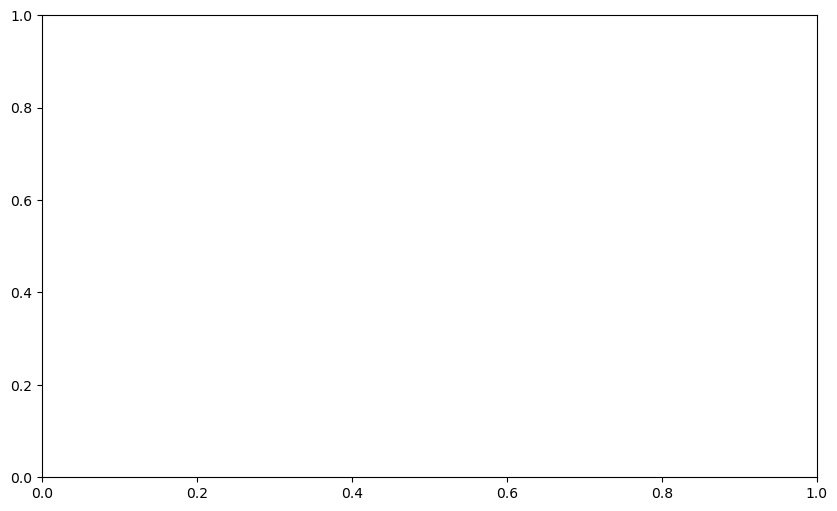

In [18]:
# Plot the results with a different color map (red-blue)
plt.figure(figsize=(10, 6))
plt.scatter(links_within_linear_ring_gdf.geometry.centroid.x, links_within_linear_ring_gdf.geometry.centroid.y, c=close_homes_count_normal, s=1, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Number of Homes within 10 meters')
plt.title('Number of Homes within 10 meters of Each Link')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Analyze results and plot

In [ ]:
# pio.analyze_geodataframes(result_dic=result_dic, consider_only_highway_edges=True)

In [ ]:
# pio.analyze_geodataframes(result_dic=result_dic, consider_only_highway_edges=False)

In [ ]:
def process_result_dic(result_dic, result_dic_mode_stats):
    datalist = []
    linegraph_transformation = LineGraph()
    base_network_no_policies = result_dic.get("base_network_no_policies")
    vol_base_case = base_network_no_policies['vol_car'].values
    capacity_base_case = base_network_no_policies['capacity'].values
    length_base_case = base_network_no_policies['length'].values
    freespeed_base_case = base_network_no_policies['freespeed'].values
    modes_base_case = encode_modes(base_network_no_policies)
    close_homes = close_homes_tensor_sparse
    
    # Initialize base edge positions
    gdf_base = gpd.GeoDataFrame(base_network_no_policies, geometry='geometry')
    gdf_base.crs = "EPSG:2154"  # Assuming the original CRS is EPSG:2154
    gdf_base.to_crs("EPSG:4326", inplace=True)
    edge_positions_base = np.array([((geom.coords[0][0] + geom.coords[-1][0]) / 2, 
                                     (geom.coords[0][1] + geom.coords[-1][1]) / 2) 
                                    for geom in gdf_base.geometry])
    
    nodes = pd.concat([gdf_base['from_node'], gdf_base['to_node']]).unique()
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}
    gdf_base['from_idx'] = gdf_base['from_node'].map(node_to_idx)
    gdf_base['to_idx'] = gdf_base['to_node'].map(node_to_idx)
    edges_base = gdf_base[['from_idx', 'to_idx']].values
    edge_positions_tensor = torch.tensor(edge_positions_base, dtype=torch.float)
    edge_index = torch.tensor(edges_base, dtype=torch.long).t().contiguous()
    x = torch.zeros((len(nodes), 1), dtype=torch.float)
    data = Data(edge_index=edge_index, x=x, pos=edge_positions_tensor)
    linegraph_data = linegraph_transformation(data)

    for key, df in tqdm(result_dic.items(), desc="Processing result_dic", unit="dataframe"):        
        if isinstance(df, pd.DataFrame) and key != "base_network_no_policies":
            gdf = gpd.GeoDataFrame(df, geometry='geometry')
            gdf.crs = "EPSG:2154"  
            gdf.to_crs("EPSG:4326", inplace=True)
            capacities_new = gdf['capacity'].values
            capacity_reduction = capacities_new - capacity_base_case
            highway = gdf['highway'].apply(lambda x: highway_mapping.get(x, -1)).values
            length = gdf['length'].values
            freespeed= gdf['freespeed'].values
            modes = encode_modes(gdf)
    
            edge_car_volume_difference = gdf['vol_car'].values - vol_base_case
            target_values = torch.tensor(edge_car_volume_difference, dtype=torch.float).unsqueeze(1)

            linegraph_x = torch.tensor(np.column_stack((vol_base_case, capacity_base_case, capacities_new, capacity_reduction, highway, length, freespeed, length_base_case, freespeed_base_case, modes, modes_base_case, close_homes)), dtype=torch.float)
            linegraph_data.x = linegraph_x
            linegraph_data.y = target_values
            
            df_mode_stats = result_dic_mode_stats.get(key)
            if df_mode_stats is not None:
                numeric_cols = df_mode_stats.select_dtypes(include=[np.number]).columns
                mode_stats_numeric = df_mode_stats[numeric_cols].astype(float)
                mode_stats_tensor = torch.tensor(mode_stats_numeric.values, dtype=torch.float)
                linegraph_data.mode_stats = mode_stats_tensor
            if linegraph_data.validate(raise_on_error=True):
                datalist.append(linegraph_data)
            else:
                print("Invalid line graph data")
    data_dict_list = [{'x': lg_data.x, 'edge_index': lg_data.edge_index, 'pos': lg_data.pos, 'y': lg_data.y, 'graph_attr': lg_data.mode_stats} for lg_data in datalist]
    return data_dict_list

data_processed = process_result_dic(result_dic=result_dic_output_links, result_dic_mode_stats=result_dic_mode_stats)
torch.save(data_processed, result_path)

Processing result_dic: 100%|██████████| 79/79 [00:07<00:00, 10.04dataframe/s]


In [ ]:
data_processed[0]

{'x': tensor([[6.6275e+00, 4.8000e+02, 4.8000e+02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.6078e+00, 4.8000e+02, 4.8000e+02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.4902e+00, 9.6000e+02, 9.6000e+02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [0.0000e+00, 7.9992e+03, 7.9992e+03,  ..., 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 7.9992e+03, 7.9992e+03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 7.9992e+03, 7.9992e+03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 'edge_index': tensor([[    0,     1,     1,  ..., 31138, 31139, 31139],
         [   19, 10935, 10936,  ..., 30278, 31138, 31139]]),
 'pos': tensor([[-1.3631, -5.9836],
         [-1.3631, -5.9836],
         [-1.3631, -5.9836],
         ...,
         [-1.3631, -5.9836],
         [-1.3631, -5.9836],
         [-1.3631, -5.9836]]),
 'y': tensor([[ 1.3725],
         [-0.6078],
         

## Save for further processing with GNN

In [ ]:
# data_processed_single_districts = pio.process_result_dic(result_dic_single_districts)
# torch.save(data_processed_single_districts, result_path + '_single_districts.pt')

In [ ]:
torch.save(data_processed, result_path)

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.scatter(persons_with_homes.geometry.x, persons_with_homes.geometry.y, s=1, color='blue', alpha=0.5)
# plt.scatter(persons_with_home_within_linear_ring.geometry.x, persons_with_home_within_linear_ring.geometry.y, s=1, color='red', alpha=0.5)
# plt.title('Locations of Persons with Homes')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

# from shapely.geometry import LineString
# from shapely.geometry import MultiPolygon
# import matplotlib.pyplot as plt

# # Create a LineString
# line = LineString([(10, 10), (20, 10)])

# # Create a buffer around the line
# buffered_line = line.buffer(2, cap_style="round")

# # Plot the original line and the buffered area
# plt.figure(figsize=(8, 6))
# x, y = line.xy
# plt.plot(x, y, color='blue', label='Original Line')
# if isinstance(buffered_line, MultiPolygon):
#     for polygon in buffered_line:
#         x, y = polygon.exterior.xy
#         plt.fill(x, y, alpha=0.5, color='lightblue', label='Buffered Area')
# else:
#     x, y = buffered_line.exterior.xy
#     plt.fill(x, y, alpha=0.5, color='lightblue', label='Buffered Area')

# plt.title('Line with Buffered Area')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()
# plt.grid()
# plt.axis('equal')
# plt.show()